# CA10: Model-Based Reinforcement Learning and Planning Methods

## Deep Reinforcement Learning - Session 10

**Comprehensive Coverage of Model-Based Reinforcement Learning**

This notebook provides a complete exploration of model-based reinforcement learning, covering theoretical foundations, planning algorithms, and practical implementations of various model-based approaches including Dyna-Q, Monte Carlo Tree Search (MCTS), Model Predictive Control (MPC), and modern neural approaches.

### Learning Objectives:
1. Understand the theoretical foundations of model-based reinforcement learning
2. Implement classical planning algorithms: Dynamic Programming, Value Iteration
3. Explore integrated planning and learning: Dyna-Q algorithm
4. Master Monte Carlo Tree Search (MCTS) and its applications
5. Implement Model Predictive Control (MPC) for continuous control
6. Understand modern neural model-based approaches
7. Compare model-based vs model-free methods
8. Apply model-based methods to complex environments

### Notebook Structure:
1. **Theoretical Foundations** - Model-based RL theory and framework
2. **Environment Models** - Learning and representing environment dynamics
3. **Classical Planning** - Dynamic Programming and Value Iteration with learned models
4. **Dyna-Q Algorithm** - Integrating planning and learning
5. **Monte Carlo Tree Search** - MCTS algorithm and applications
6. **Model Predictive Control** - MPC for continuous control problems
7. **Modern Neural Methods** - World models and neural planning
8. **Comparative Analysis** - Model-based vs model-free comparison

---

In [4]:
# Essential Imports and Environment Setup
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical, Normal
import gymnasium as gym
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import defaultdict, deque
import random
import pickle
from typing import Tuple, List, Dict, Optional, Union
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Plotting configuration
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("Environment setup complete!")
print(f"PyTorch version: {torch.__version__}")
print(f"Gymnasium version: {gym.__version__}")
print(f"NumPy version: {np.__version__}")

# Import local CA10 modules (use .py implementations)
import os, sys, importlib
# Ensure repo root / notebook dir is on path
sys.path.append(os.path.dirname(os.path.abspath('__file__')))

import classical_planning, comparison, dyna_q, mcts, mpc, models, environments
# Reload to pick up local edits
importlib.reload(classical_planning)
importlib.reload(comparison)
importlib.reload(dyna_q)
importlib.reload(mcts)
importlib.reload(mpc)
importlib.reload(models)
importlib.reload(environments)

# Expose key classes/functions into notebook namespace for convenience
from classical_planning import (
    ModelBasedPlanner,
    UncertaintyAwarePlanner,
    ModelBasedPolicySearch,
)
from dyna_q import DynaQAgent, DynaQPlusAgent
from mcts import MCTSAgent
from mpc import MPCAgent, MPCController
from models import TabularModel, NeuralModel, ModelTrainer, device as models_device
from environments import SimpleGridWorld, BlockingMaze

# Keep device in sync (notebook-level variable)
device = models_device

print("Imported CA10 modules from .py files")

Using device: cpu
Environment setup complete!
PyTorch version: 2.0.1
Gymnasium version: 1.2.1
NumPy version: 1.26.4
Using device: cpu
Environment setup complete!
PyTorch version: 2.0.1
Gymnasium version: 1.2.1
NumPy version: 1.26.4
Imported CA10 modules from .py files


# Section 1: Theoretical Foundations of Model-Based Reinforcement Learning

## 1.1 From Model-Free to Model-Based Learning

In our journey through reinforcement learning, we have primarily focused on **model-free methods** such as Q-learning, SARSA, and policy gradient methods. These methods learn directly from experience without explicitly modeling the environment. However, there are fundamental advantages to learning and using environment models:

### Model-Free vs Model-Based Comparison

| Aspect | Model-Free Methods | Model-Based Methods |
|--------|-------------------|--------------------|
| **Learning** | Learn value functions or policies directly | Learn environment model first |
| **Sample Efficiency** | Generally less sample efficient | Generally more sample efficient |
| **Computational Cost** | Lower per-step computation | Higher per-step computation |
| **Planning** | No explicit planning | Can plan with learned model |
| **Robustness** | More robust to model errors | Sensitive to model inaccuracies |
| **Interpretability** | Less interpretable | More interpretable (explicit model) |

## 1.2 The Model-Based RL Framework

The general model-based RL framework consists of three main components:

1. **Model Learning**: Learn a model of the environment from experience
   $$\hat{P}(s'|s,a) \approx P(s'|s,a)$$
   $$\hat{R}(s,a) \approx E[R|s,a]$$

2. **Planning**: Use the learned model to compute optimal policies
   - Value iteration with learned model
   - Policy iteration with learned model  
   - Monte Carlo Tree Search
   - Model Predictive Control

3. **Acting**: Execute actions in the real environment
   - Collect new experience
   - Update the model
   - Replan with improved model

## 1.3 Advantages of Model-Based Methods

**Sample Efficiency**: 
- Can generate synthetic experience using the learned model
- Each real experience can be used multiple times for planning
- Particularly important in expensive real-world applications

**Transfer Learning**:
- Models can transfer across different tasks in the same environment
- Learned dynamics are often more general than policies

**Interpretability and Safety**:
- Explicit models provide insight into system behavior
- Can simulate outcomes before taking actions
- Enable safety verification and constraint checking

**Planning Capabilities**:
- Can look ahead and plan optimal sequences of actions
- Adapt quickly to changes in rewards or goals
- Enable hierarchical and long-term planning

## 1.4 Challenges in Model-Based RL

**Model Bias and Compounding Errors**:
- Errors in the learned model can compound over time
- Model bias can lead to suboptimal policies
- Challenge: Learning accurate models in complex environments

**Computational Complexity**:
- Planning with models can be computationally expensive
- Trade-off between planning depth and computational cost

**Partial Observability**:
- Real environments often have hidden state
- Challenge: Learning models from partial observations

**Stochastic Environments**:
- Need to model uncertainty in transitions and rewards
- Balance between model complexity and accuracy

Model-Based RL Framework Visualizations

1. Framework Comparison:


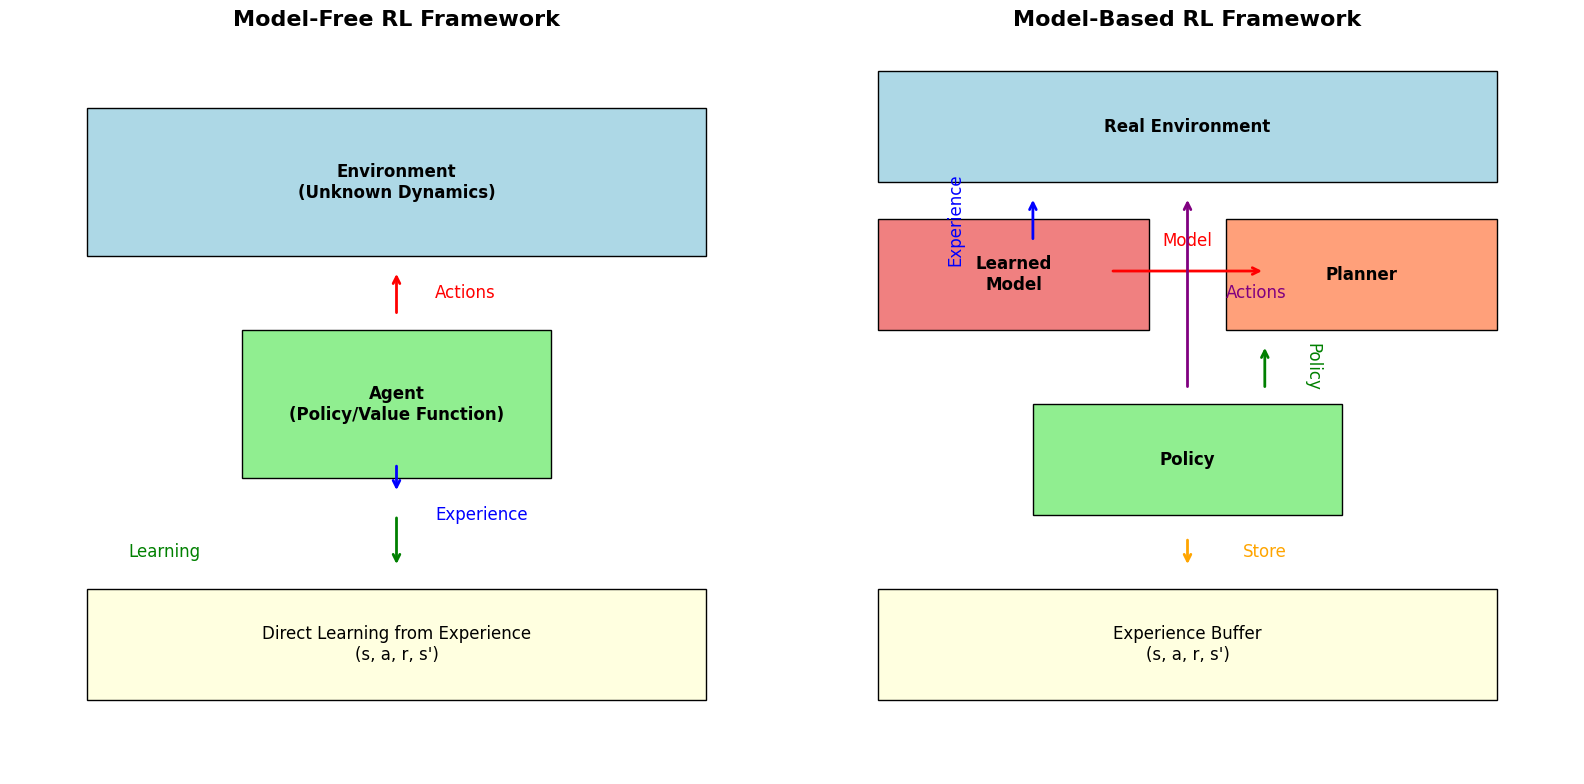


2. Sample Efficiency Analysis:


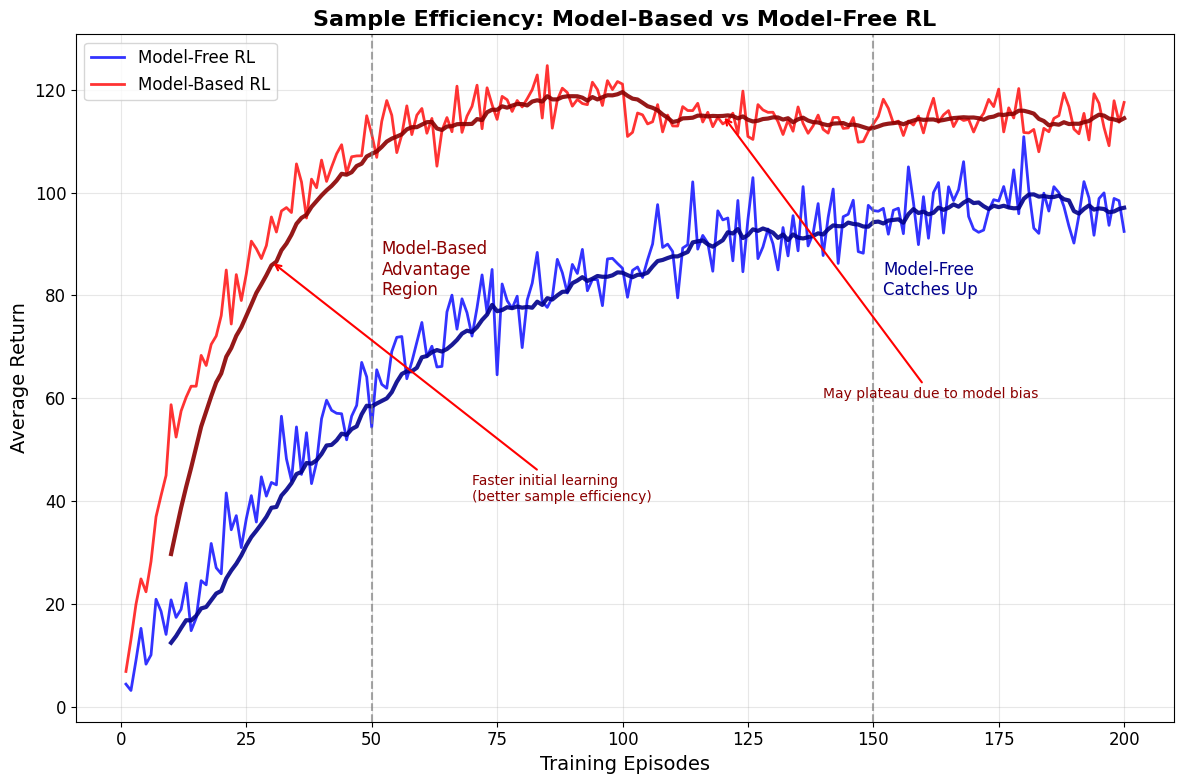


3. Comprehensive Comparison Table:


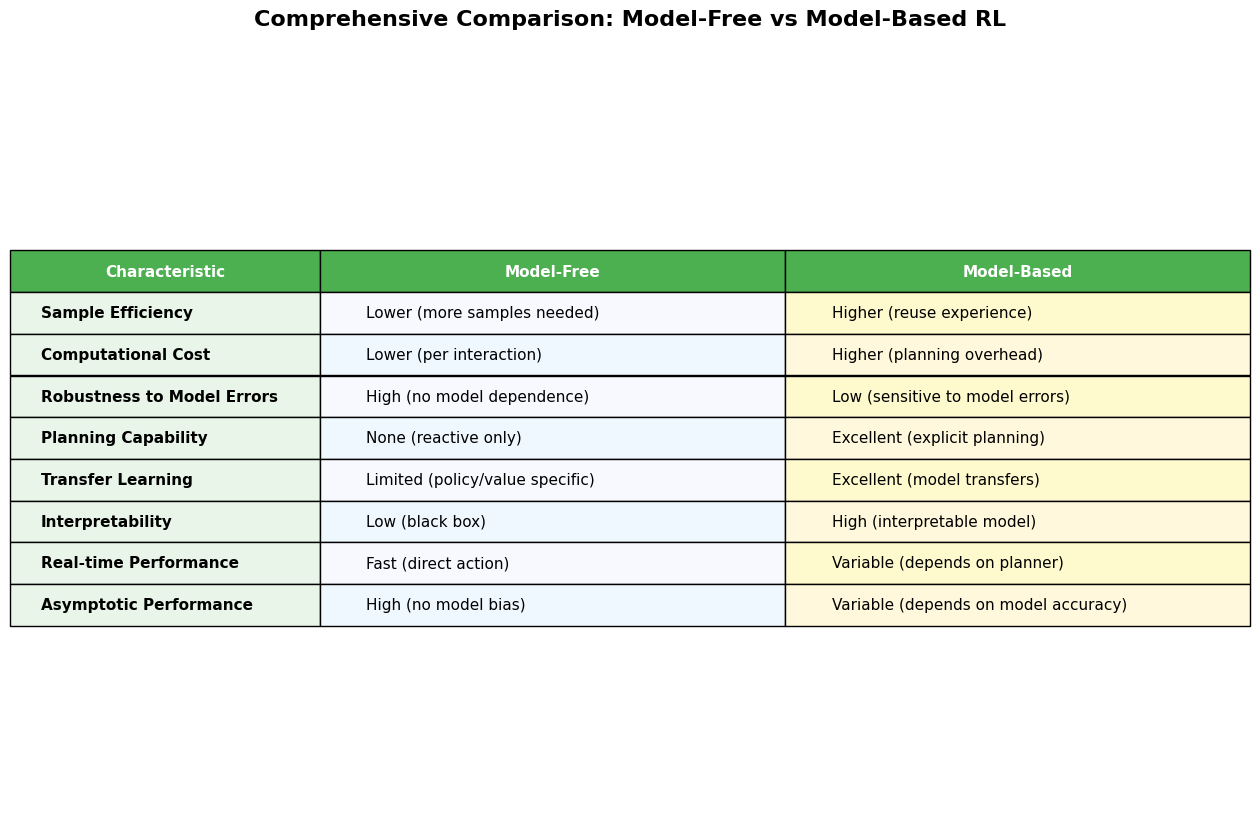


✅ Theoretical foundations established!
📊 Next: Environment model learning and representation


In [3]:
# Theoretical Foundation Visualization

class ModelBasedFrameworkVisualizer:
    """Visualize the model-based RL framework and concepts"""
    
    def visualize_framework_comparison(self):
        """Compare model-free vs model-based frameworks"""
        
        fig, axes = plt.subplots(1, 2, figsize=(16, 8))
        
        # Model-Free Framework
        ax = axes[0]
        ax.set_xlim(0, 10)
        ax.set_ylim(0, 10)
        ax.set_title('Model-Free RL Framework', fontsize=16, fontweight='bold')
        
        # Components
        env_box = plt.Rectangle((1, 7), 8, 2, fill=True, facecolor='lightblue', edgecolor='black')
        ax.add_patch(env_box)
        ax.text(5, 8, 'Environment\n(Unknown Dynamics)', ha='center', va='center', fontweight='bold')
        
        agent_box = plt.Rectangle((3, 4), 4, 2, fill=True, facecolor='lightgreen', edgecolor='black')
        ax.add_patch(agent_box)
        ax.text(5, 5, 'Agent\n(Policy/Value Function)', ha='center', va='center', fontweight='bold')
        
        experience_box = plt.Rectangle((1, 1), 8, 1.5, fill=True, facecolor='lightyellow', edgecolor='black')
        ax.add_patch(experience_box)
        ax.text(5, 1.75, 'Direct Learning from Experience\n(s, a, r, s\')', ha='center', va='center')
        
        # Arrows
        ax.annotate('', xy=(5, 6.8), xytext=(5, 6.2), arrowprops=dict(arrowstyle='->', lw=2, color='red'))
        ax.text(5.5, 6.5, 'Actions', ha='left', va='center', color='red')
        
        ax.annotate('', xy=(5, 3.8), xytext=(5, 4.2), arrowprops=dict(arrowstyle='->', lw=2, color='blue'))
        ax.text(5.5, 3.5, 'Experience', ha='left', va='center', color='blue')
        
        ax.annotate('', xy=(5, 2.8), xytext=(5, 3.5), arrowprops=dict(arrowstyle='->', lw=2, color='green'))
        ax.text(2, 3, 'Learning', ha='center', va='center', color='green')
        
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        
        # Model-Based Framework
        ax = axes[1]
        ax.set_xlim(0, 10)
        ax.set_ylim(0, 10)
        ax.set_title('Model-Based RL Framework', fontsize=16, fontweight='bold')
        
        # Components
        env_box = plt.Rectangle((1, 8), 8, 1.5, fill=True, facecolor='lightblue', edgecolor='black')
        ax.add_patch(env_box)
        ax.text(5, 8.75, 'Real Environment', ha='center', va='center', fontweight='bold')
        
        model_box = plt.Rectangle((1, 6), 3.5, 1.5, fill=True, facecolor='lightcoral', edgecolor='black')
        ax.add_patch(model_box)
        ax.text(2.75, 6.75, 'Learned\nModel', ha='center', va='center', fontweight='bold')
        
        planner_box = plt.Rectangle((5.5, 6), 3.5, 1.5, fill=True, facecolor='lightsalmon', edgecolor='black')
        ax.add_patch(planner_box)
        ax.text(7.25, 6.75, 'Planner', ha='center', va='center', fontweight='bold')
        
        policy_box = plt.Rectangle((3, 3.5), 4, 1.5, fill=True, facecolor='lightgreen', edgecolor='black')
        ax.add_patch(policy_box)
        ax.text(5, 4.25, 'Policy', ha='center', va='center', fontweight='bold')
        
        experience_box = plt.Rectangle((1, 1), 8, 1.5, fill=True, facecolor='lightyellow', edgecolor='black')
        ax.add_patch(experience_box)
        ax.text(5, 1.75, 'Experience Buffer\n(s, a, r, s\')', ha='center', va='center')
        
        # Arrows with labels
        ax.annotate('', xy=(3, 7.8), xytext=(3, 7.2), arrowprops=dict(arrowstyle='->', lw=2, color='blue'))
        ax.text(2, 7.5, 'Experience', ha='center', va='center', color='blue', rotation=90)
        
        ax.annotate('', xy=(6, 6.8), xytext=(4, 6.8), arrowprops=dict(arrowstyle='->', lw=2, color='red'))
        ax.text(5, 7.2, 'Model', ha='center', va='center', color='red')
        
        ax.annotate('', xy=(6, 5.8), xytext=(6, 5.2), arrowprops=dict(arrowstyle='->', lw=2, color='green'))
        ax.text(6.5, 5.5, 'Policy', ha='left', va='center', color='green', rotation=-90)
        
        ax.annotate('', xy=(5, 7.8), xytext=(5, 5.2), arrowprops=dict(arrowstyle='->', lw=2, color='purple'))
        ax.text(5.5, 6.5, 'Actions', ha='left', va='center', color='purple')
        
        ax.annotate('', xy=(5, 2.8), xytext=(5, 3.2), arrowprops=dict(arrowstyle='->', lw=2, color='orange'))
        ax.text(6, 3, 'Store', ha='center', va='center', color='orange')
        
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        
        plt.tight_layout()
        plt.show()
    
    def visualize_sample_efficiency(self):
        """Visualize sample efficiency comparison"""
        
        episodes = np.arange(1, 201)
        
        # Simulate learning curves
        np.random.seed(42)
        
        # Model-free: slower initial learning but eventually converges
        model_free = 100 * (1 - np.exp(-episodes/50)) + np.random.normal(0, 5, len(episodes))
        model_free = np.maximum(0, model_free)
        
        # Model-based: faster initial learning but may plateau due to model bias
        model_based = 120 * (1 - np.exp(-episodes/20)) + np.random.normal(0, 3, len(episodes))
        model_based = np.maximum(0, model_based)
        # Add some bias that causes plateau
        model_based[100:] *= 0.95
        
        plt.figure(figsize=(12, 8))
        
        plt.plot(episodes, model_free, label='Model-Free RL', linewidth=2, color='blue', alpha=0.8)
        plt.plot(episodes, model_based, label='Model-Based RL', linewidth=2, color='red', alpha=0.8)
        
        # Add smoothed versions
        window = 10
        model_free_smooth = pd.Series(model_free).rolling(window).mean()
        model_based_smooth = pd.Series(model_based).rolling(window).mean()
        
        plt.plot(episodes, model_free_smooth, linewidth=3, color='darkblue', alpha=0.9)
        plt.plot(episodes, model_based_smooth, linewidth=3, color='darkred', alpha=0.9)
        
        plt.axvline(x=50, color='gray', linestyle='--', alpha=0.7)
        plt.text(52, 80, 'Model-Based\nAdvantage\nRegion', fontsize=12, color='darkred')
        
        plt.axvline(x=150, color='gray', linestyle='--', alpha=0.7)
        plt.text(152, 80, 'Model-Free\nCatches Up', fontsize=12, color='darkblue')
        
        plt.xlabel('Training Episodes', fontsize=14)
        plt.ylabel('Average Return', fontsize=14)
        plt.title('Sample Efficiency: Model-Based vs Model-Free RL', fontsize=16, fontweight='bold')
        plt.legend(fontsize=12)
        plt.grid(True, alpha=0.3)
        
        # Add annotations
        plt.annotate('Faster initial learning\n(better sample efficiency)', 
                    xy=(30, model_based_smooth.iloc[30]), xytext=(70, 40),
                    arrowprops=dict(arrowstyle='->', color='red', lw=1.5),
                    fontsize=10, color='darkred')
        
        plt.annotate('May plateau due to model bias', 
                    xy=(120, model_based_smooth.iloc[120]), xytext=(140, 60),
                    arrowprops=dict(arrowstyle='->', color='red', lw=1.5),
                    fontsize=10, color='darkred')
        
        plt.tight_layout()
        plt.show()
    
    def create_summary_table(self):
        """Create comprehensive comparison table"""
        
        comparison_data = {
            'Characteristic': [
                'Sample Efficiency',
                'Computational Cost',
                'Robustness to Model Errors',
                'Planning Capability',
                'Transfer Learning',
                'Interpretability',
                'Real-time Performance',
                'Asymptotic Performance'
            ],
            'Model-Free': [
                'Lower (more samples needed)',
                'Lower (per interaction)',
                'High (no model dependence)',
                'None (reactive only)',
                'Limited (policy/value specific)',
                'Low (black box)',
                'Fast (direct action)',
                'High (no model bias)'
            ],
            'Model-Based': [
                'Higher (reuse experience)',
                'Higher (planning overhead)',
                'Low (sensitive to model errors)',
                'Excellent (explicit planning)',
                'Excellent (model transfers)',
                'High (interpretable model)',
                'Variable (depends on planner)',
                'Variable (depends on model accuracy)'
            ]
        }
        
        df = pd.DataFrame(comparison_data)
        
        fig, ax = plt.subplots(figsize=(16, 10))
        ax.axis('tight')
        ax.axis('off')
        
        table = ax.table(cellText=df.values,
                        colLabels=df.columns,
                        cellLoc='left',
                        loc='center',
                        colWidths=[0.25, 0.375, 0.375])
        
        table.auto_set_font_size(False)
        table.set_fontsize(11)
        table.scale(1, 2.5)
        
        # Style the header
        for i in range(len(df.columns)):
            table[(0, i)].set_facecolor('#4CAF50')
            table[(0, i)].set_text_props(weight='bold', color='white')
        
        # Style the rows
        for i in range(1, len(df) + 1):
            table[(i, 0)].set_facecolor('#E8F5E8')
            table[(i, 0)].set_text_props(weight='bold')
            
            if i % 2 == 0:
                table[(i, 1)].set_facecolor('#F0F8FF')
                table[(i, 2)].set_facecolor('#FFF8DC')
            else:
                table[(i, 1)].set_facecolor('#F8F8FF')
                table[(i, 2)].set_facecolor('#FFFACD')
        
        plt.title('Comprehensive Comparison: Model-Free vs Model-Based RL', 
                 fontsize=16, fontweight='bold', pad=20)
        plt.show()
        
        return df

# Create and run visualizations
visualizer = ModelBasedFrameworkVisualizer()

print("Model-Based RL Framework Visualizations")
print("="*50)

print("\n1. Framework Comparison:")
visualizer.visualize_framework_comparison()

print("\n2. Sample Efficiency Analysis:")
visualizer.visualize_sample_efficiency()

print("\n3. Comprehensive Comparison Table:")
comparison_df = visualizer.create_summary_table()

print("\n✅ Theoretical foundations established!")
print("📊 Next: Environment model learning and representation")

# Section 2: Environment Models and Model Learning

## 2.1 Types of Environment Models

Environment models can be categorized along several dimensions:

### By Representation Type:

**Tabular Models**:
- Store explicit transition probabilities: $P(s'|s,a)$
- Store explicit rewards: $R(s,a)$
- Suitable for small, discrete state-action spaces
- Example: Storing counts and computing maximum likelihood estimates

**Function Approximation Models**:
- Use neural networks to approximate dynamics
- $s' = f_\theta(s,a) + \epsilon$ (deterministic + noise)
- $P(s'|s,a) = \pi_\theta(s'|s,a)$ (stochastic)
- Suitable for large, continuous state-action spaces

### By Uncertainty Representation:

**Deterministic Models**:
- Predict single next state: $s' = f(s,a)$
- Simple but ignores environment stochasticity
- Can add noise independently

**Stochastic Models**:
- Predict distribution over next states: $P(s'|s,a)$
- More accurate for stochastic environments
- Can be parametric (Gaussian) or non-parametric

**Ensemble Models**:
- Multiple models trained on different data subsets
- Uncertainty estimated from ensemble disagreement
- More robust and better uncertainty quantification

## 2.2 Model Learning Approaches

### Maximum Likelihood Estimation (MLE)

For tabular environments, we can use simple counting:
$$\hat{P}(s'|s,a) = \frac{N(s,a,s')}{N(s,a)}$$
$$\hat{R}(s,a) = \frac{1}{N(s,a)} \sum_{i} R_i(s,a)$$

### Neural Network Models

For complex environments, use neural networks:
- **Forward Model**: $(s,a) \rightarrow (s', r)$
- **Inverse Model**: $(s,s') \rightarrow a$
- **Combined**: Learn both forward and inverse models jointly

### Training Objectives

**Deterministic Dynamics**:
$$L = \mathbb{E}_{(s,a,s',r) \sim D}[||s' - f_\theta(s,a)||^2 + ||r - g_\theta(s,a)||^2]$$

**Stochastic Dynamics**:
$$L = -\mathbb{E}_{(s,a,s',r) \sim D}[\log P_\theta(s'|s,a) + \log P_\theta(r|s,a)]$$

## 2.3 Model Validation and Selection

### Validation Strategies

**Hold-out Validation**:
- Split data into training and validation sets
- Evaluate model accuracy on unseen transitions
- Risk: May not reflect planning performance

**Cross-Validation**:
- Multiple train/validation splits
- More robust estimate of model quality
- Higher computational cost

**Policy-Aware Validation**:
- Evaluate model on states visited by current policy
- More relevant for planning performance
- Adapts as policy changes

### Model Selection Criteria

**Prediction Accuracy**:
- Mean squared error for continuous states
- Cross-entropy for discrete states
- May not correlate with planning performance

**Planning Performance**:
- Evaluate policies learned with the model
- More relevant but computationally expensive
- Gold standard when feasible

**Uncertainty Calibration**:
- Ensure predicted uncertainty matches actual errors
- Important for robust planning
- Use reliability diagrams and calibration error

In [1]:
# Environment Models Implementation

# Import from modular files
from models import TabularModel, NeuralModel, ModelTrainer
from environments import SimpleGridWorld

# Demonstrate model learning
print("Environment Model Learning Demonstration")
print("=" * 50)

# Create environment and collect data
env = SimpleGridWorld(size=4)
tabular_model = TabularModel(env.num_states, env.num_actions)

# Collect experience
n_episodes = 1000
experience_data = []

print("\n1. Collecting experience...")
for episode in range(n_episodes):
    state = env.reset()
    done = False
    
    while not done:
        action = np.random.randint(env.num_actions)  # Random policy
        next_state, reward, done = env.step(action)
        
        # Update tabular model
        tabular_model.update(state, action, next_state, reward)
        
        # Store for neural model
        experience_data.append((state, action, next_state, reward))
        
        state = next_state

print(f"Collected {len(experience_data)} transitions")

# Prepare data for neural model
states = np.array([exp[0] for exp in experience_data])
actions = np.array([exp[1] for exp in experience_data])
next_states = np.array([exp[2] for exp in experience_data])
rewards = np.array([exp[3] for exp in experience_data])

# Convert states to one-hot for neural model
states_onehot = np.eye(env.num_states)[states]
next_states_onehot = np.eye(env.num_states)[next_states]

# Train neural model
print("\n2. Training neural model...")
neural_model = NeuralModel(env.num_states, env.num_actions, hidden_dim=64, ensemble_size=3).to(device)
trainer = ModelTrainer(neural_model, lr=1e-3)

trainer.train_batch((states_onehot, actions, next_states_onehot, rewards), epochs=50, batch_size=64)

print("\n3. Model accuracy comparison:")

# Test model accuracy
test_states = np.random.randint(0, env.num_states, 100)
test_actions = np.random.randint(0, env.num_actions, 100)

tabular_errors = []
neural_errors = []

for s, a in zip(test_states, test_actions):
    # Get true transition (using many samples)
    true_next_states = []
    true_rewards = []
    
    for _ in range(50):
        env.state = s
        next_state, reward, _ = env.step(a)
        true_next_states.append(next_state)
        true_rewards.append(reward)
    
    true_reward = np.mean(true_rewards)
    
    # Tabular model prediction
    pred_reward_tabular = tabular_model.get_expected_reward(s, a)
    tabular_errors.append(abs(true_reward - pred_reward_tabular))
    
    # Neural model prediction
    state_tensor = torch.FloatTensor(np.eye(env.num_states)[s]).to(device)
    action_tensor = torch.LongTensor([a]).to(device)
    _, pred_reward_neural = neural_model(state_tensor, action_tensor)
    pred_reward_neural = pred_reward_neural.cpu().item()
    neural_errors.append(abs(true_reward - pred_reward_neural))

print(f"Tabular model MAE: {np.mean(tabular_errors):.4f}")
print(f"Neural model MAE: {np.mean(neural_errors):.4f}")

# Visualize training progress
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(trainer.loss_history)
plt.title('Neural Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.bar(['Tabular Model', 'Neural Model'], [np.mean(tabular_errors), np.mean(neural_errors)], 
        color=['blue', 'red'], alpha=0.7)
plt.title('Model Accuracy Comparison')
plt.ylabel('Mean Absolute Error')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Environment model learning complete!")
print("📊 Next: Classical planning with learned models")

Using device: cpu
Environment setup complete!
PyTorch version: 2.0.1
Gymnasium version: 1.2.1
NumPy version: 1.26.4
Environment Model Learning Demonstration

1. Collecting experience...


NameError: name 'np' is not defined

# Section 3: Classical Planning with Learned Models

## 3.1 Dynamic Programming with Learned Models

Once we have learned an environment model, we can use classical dynamic programming algorithms to compute optimal policies. This is one of the most straightforward applications of model-based RL.

### Value Iteration with Learned Models

The Value Iteration algorithm can be applied directly using our learned transition probabilities and rewards:

$$V_{k+1}(s) = \max_a \sum_{s'} \hat{P}(s'|s,a)[\hat{R}(s,a,s') + \gamma V_k(s')]$$

**Key Advantages:**
- Guaranteed convergence to optimal policy (if model is accurate)
- Can compute policy for all states simultaneously
- No need for exploration during planning phase

**Potential Issues:**
- Model errors compound over planning horizon
- Assumes learned model is accurate
- May overfit to limited experience

### Policy Iteration with Learned Models

Policy Iteration alternates between policy evaluation and policy improvement using the learned model:

**Policy Evaluation:**
$$V^\pi(s) = \sum_{s'} \hat{P}(s'|s,\pi(s))[\hat{R}(s,\pi(s),s') + \gamma V^\pi(s')]$$

**Policy Improvement:**
$$\pi'(s) = \arg\max_a \sum_{s'} \hat{P}(s'|s,a)[\hat{R}(s,a,s') + \gamma V^\pi(s')]$$

## 3.2 Handling Model Uncertainty

Real learned models have uncertainty. Several approaches address this:

### Pessimistic Planning
- Use lower confidence bounds for model predictions
- $\hat{P}_{pessimistic}(s'|s,a) = \hat{P}(s'|s,a) - \beta \sigma(s'|s,a)$
- Leads to more robust but potentially conservative policies

### Optimistic Planning  
- Use upper confidence bounds for model predictions
- Encourages exploration of uncertain regions
- Can lead to more aggressive exploration policies

### Robust Planning
- Optimize for worst-case model within confidence region
- $\max_\pi \min_{M \in \mathcal{U}} V^\pi_M$
- Very conservative but safe approach

## 3.3 Model-Based Policy Search

Instead of computing value functions, we can directly search in policy space using the learned model:

### Gradient-Based Policy Search
- Use model to compute policy gradients
- $\nabla_\theta J(\theta) = \mathbb{E}_{\tau \sim \pi_\theta, M}[\sum_t \nabla_\theta \log \pi_\theta(a_t|s_t) R(\tau)]$
- Generate synthetic rollouts with learned model

### Evolutionary Policy Search
- Maintain population of policy parameters
- Evaluate policies using learned model
- Select and mutate best policies

### Random Shooting
- Sample random action sequences
- Evaluate using learned model
- Select best sequence and execute first action

In [8]:
# Classical Planning Implementation

class ModelBasedPlanner:
    """Classical planning algorithms using learned models"""
    
    def __init__(self, model, num_states, num_actions, gamma=0.99):
        self.model = model
        self.num_states = num_states
        self.num_actions = num_actions
        self.gamma = gamma
        
        # Initialize value function and policy
        self.V = np.zeros(num_states)
        self.policy = np.zeros(num_states, dtype=int)
        
        # Planning history for analysis
        self.value_history = []
        self.policy_history = []
    
    def value_iteration(self, max_iterations=100, tolerance=1e-6):
        """Value Iteration using learned model"""
        
        print(f"Running Value Iteration (max_iter={max_iterations}, tol={tolerance})")
        
        for iteration in range(max_iterations):
            old_V = self.V.copy()
            
            for state in range(self.num_states):
                # Compute Q-values for all actions
                q_values = np.zeros(self.num_actions)
                
                for action in range(self.num_actions):
                    # Compute expected value using model
                    expected_value = 0
                    
                    for next_state in range(self.num_states):
                        transition_prob = self.model.get_transition_prob(state, action, next_state)
                        reward = self.model.get_expected_reward(state, action)
                        expected_value += transition_prob * (reward + self.gamma * old_V[next_state])
                    
                    q_values[action] = expected_value
                
                # Update value and policy
                self.V[state] = np.max(q_values)
                self.policy[state] = np.argmax(q_values)
            
            # Store history
            self.value_history.append(self.V.copy())
            self.policy_history.append(self.policy.copy())
            
            # Check convergence
            if np.max(np.abs(self.V - old_V)) < tolerance:
                print(f"Converged after {iteration + 1} iterations")
                break
        
        return self.V, self.policy
    
    def policy_iteration(self, max_iterations=50, eval_max_iterations=100):
        """Policy Iteration using learned model"""
        
        print(f"Running Policy Iteration (max_iter={max_iterations})")
        
        # Initialize random policy
        self.policy = np.random.randint(0, self.num_actions, self.num_states)
        
        for iteration in range(max_iterations):
            old_policy = self.policy.copy()
            
            # Policy Evaluation
            self.V = self.policy_evaluation(self.policy, max_iterations=eval_max_iterations)
            
            # Policy Improvement
            for state in range(self.num_states):
                q_values = np.zeros(self.num_actions)
                
                for action in range(self.num_actions):
                    expected_value = 0
                    
                    for next_state in range(self.num_states):
                        transition_prob = self.model.get_transition_prob(state, action, next_state)
                        reward = self.model.get_expected_reward(state, action)
                        expected_value += transition_prob * (reward + self.gamma * self.V[next_state])
                    
                    q_values[action] = expected_value
                
                self.policy[state] = np.argmax(q_values)
            
            # Store history
            self.value_history.append(self.V.copy())
            self.policy_history.append(self.policy.copy())
            
            # Check convergence
            if np.array_equal(self.policy, old_policy):
                print(f"Converged after {iteration + 1} iterations")
                break
        
        return self.V, self.policy
    
    def policy_evaluation(self, policy, max_iterations=100, tolerance=1e-6):
        """Evaluate a given policy using learned model"""
        
        V = np.zeros(self.num_states)
        
        for iteration in range(max_iterations):
            old_V = V.copy()
            
            for state in range(self.num_states):
                action = policy[state]
                expected_value = 0
                
                for next_state in range(self.num_states):
                    transition_prob = self.model.get_transition_prob(state, action, next_state)
                    reward = self.model.get_expected_reward(state, action)
                    expected_value += transition_prob * (reward + self.gamma * old_V[next_state])
                
                V[state] = expected_value
            
            if np.max(np.abs(V - old_V)) < tolerance:
                break
        
        return V
    
    def compute_q_function(self):
        """Compute Q-function from current value function"""
        
        Q = np.zeros((self.num_states, self.num_actions))
        
        for state in range(self.num_states):
            for action in range(self.num_actions):
                expected_value = 0
                
                for next_state in range(self.num_states):
                    transition_prob = self.model.get_transition_prob(state, action, next_state)
                    reward = self.model.get_expected_reward(state, action)
                    expected_value += transition_prob * (reward + self.gamma * self.V[next_state])
                
                Q[state, action] = expected_value
        
        return Q

class UncertaintyAwarePlanner:
    """Planning with model uncertainty"""
    
    def __init__(self, ensemble_model, num_states, num_actions, gamma=0.99):
        self.ensemble_model = ensemble_model
        self.num_states = num_states
        self.num_actions = num_actions
        self.gamma = gamma
        
    def pessimistic_value_iteration(self, beta=1.0, max_iterations=100):
        """Value iteration with pessimistic model estimates"""
        
        V = np.zeros(self.num_states)
        policy = np.zeros(self.num_states, dtype=int)
        
        print(f"Running Pessimistic Value Iteration (beta={beta})")
        
        for iteration in range(max_iterations):
            old_V = V.copy()
            
            for state in range(self.num_states):
                q_values = np.zeros(self.num_actions)
                
                for action in range(self.num_actions):
                    # Get predictions from ensemble
                    state_onehot = np.eye(self.num_states)[state:state+1]
                    action_tensor = np.array([action])
                    
                    # Convert to tensors
                    state_tensor = torch.FloatTensor(state_onehot).to(device)
                    action_tensor = torch.LongTensor(action_tensor).to(device)
                    
                    # Get ensemble predictions
                    next_state_mean, reward_mean, next_state_std, reward_std = \
                        self.ensemble_model.predict_with_uncertainty(state_tensor, action_tensor)\n",
                    \n",
                    # Use pessimistic estimates\n",
                    pessimistic_reward = reward_mean.cpu().item() - beta * reward_std.cpu().item()\n",
                    \n",
                    # For simplicity, assume deterministic next state (can be extended)\n",
                    next_state_pred = next_state_mean.cpu().numpy()[0]\n",
                    next_state_idx = np.argmax(next_state_pred)  # Most likely next state\n",
                    \n",
                    q_values[action] = pessimistic_reward + self.gamma * old_V[next_state_idx]\n",
                \n",
                V[state] = np.max(q_values)\n",
                policy[state] = np.argmax(q_values)\n",
            \n",
            if np.max(np.abs(V - old_V)) < 1e-6:\n",
                print(f\"Converged after {iteration + 1} iterations\")\n",
                break\n",
        \n",
        return V, policy\n",
    \n",
    def optimistic_value_iteration(self, beta=1.0, max_iterations=100):\n",
        \"\"\"Value iteration with optimistic model estimates\"\"\"\n",
        \n",
        V = np.zeros(self.num_states)\n",
        policy = np.zeros(self.num_states, dtype=int)\n",
        \n",
        print(f\"Running Optimistic Value Iteration (beta={beta})\")\n",
        \n",
        for iteration in range(max_iterations):\n",
            old_V = V.copy()\n",
            \n",
            for state in range(self.num_states):\n",
                q_values = np.zeros(self.num_actions)\n",
                \n",
                for action in range(self.num_actions):\n",
                    # Get predictions from ensemble\n",
                    state_onehot = np.eye(self.num_states)[state:state+1]\n",
                    action_tensor = np.array([action])\n",
                    \n",
                    # Convert to tensors\n",
                    state_tensor = torch.FloatTensor(state_onehot).to(device)\n",
                    action_tensor = torch.LongTensor(action_tensor).to(device)\n",
                    \n",
                    # Get ensemble predictions\n",
                    next_state_mean, reward_mean, next_state_std, reward_std = \\\n",
                        self.ensemble_model.predict_with_uncertainty(state_tensor, action_tensor)\n",
                    \n",
                    # Use optimistic estimates\n",
                    optimistic_reward = reward_mean.cpu().item() + beta * reward_std.cpu().item()\n",
                    \n",
                    # For simplicity, assume deterministic next state\n",
                    next_state_pred = next_state_mean.cpu().numpy()[0]\n",
                    next_state_idx = np.argmax(next_state_pred)\n",
                    \n",
                    q_values[action] = optimistic_reward + self.gamma * old_V[next_state_idx]\n",
                \n",
                V[state] = np.max(q_values)\n",
                policy[state] = np.argmax(q_values)\n",
            \n",
            if np.max(np.abs(V - old_V)) < 1e-6:\n",
                print(f\"Converged after {iteration + 1} iterations\")\n",
                break\n",
        \n",
        return V, policy\n",
"\n",
"class ModelBasedPolicySearch:\n",
"    \"\"\"Policy search using learned models\"\"\"\n",
"    \n",
"    def __init__(self, model, state_dim, action_dim, gamma=0.99):\n",
"        self.model = model\n",
"        self.state_dim = state_dim\n",
"        self.action_dim = action_dim\n",
"        self.gamma = gamma\n",
"    \n",
"    def random_shooting(self, initial_state, horizon=10, num_sequences=1000):\n",
"        \"\"\"Random shooting with learned model\"\"\"\n",
"        \n",
"        best_sequence = None\n",
"        best_value = -np.inf\n",
"        \n",
"        for _ in range(num_sequences):\n",
"            # Sample random action sequence\n",
"            action_sequence = np.random.randint(0, self.action_dim, horizon)\n",
"            \n",
"            # Evaluate sequence using model\n",
"            total_reward = 0\n",
"            current_state = initial_state\n",
"            discount = 1.0\n",
"            \n",
"            for action in action_sequence:\n",
"                next_state, reward = self.model.sample_transition(current_state, action)\n",
"                total_reward += discount * reward\n",
"                discount *= self.gamma\n",
"                current_state = next_state\n",
"            \n",
"            if total_reward > best_value:\n",
"                best_value = total_reward\n",
"                best_sequence = action_sequence\n",
"        \n",
"        return best_sequence, best_value\n",
"    \n",
"    def cross_entropy_method(self, initial_state, horizon=10, num_sequences=1000, \n",
"                           num_elite=100, num_iterations=10):\n",
"        \"\"\"Cross-entropy method for policy search\"\"\"\n",
"        \n",
"        # Initialize action probabilities (uniform)\n",
"        action_probs = np.ones((horizon, self.action_dim)) / self.action_dim\n",
"        \n",
"        for iteration in range(num_iterations):\n",
"            # Sample action sequences\n",
"            sequences = []\n",
"            values = []\n",
"            \n",
"            for _ in range(num_sequences):\n",
"                sequence = []\n",
"                for t in range(horizon):\n",
"                    action = np.random.choice(self.action_dim, p=action_probs[t])\n",
"                    sequence.append(action)\n",
"                \n",
"                # Evaluate sequence\n",
"                total_reward = 0\n",
"                current_state = initial_state\n",
"                discount = 1.0\n",
"                \n",
"                for action in sequence:\n",
"                    next_state, reward = self.model.sample_transition(current_state, action)\n",
"                    total_reward += discount * reward\n",
"                    discount *= self.gamma\n",
"                    current_state = next_state\n",
"                \n",
"                sequences.append(sequence)\n",
"                values.append(total_reward)\n",
"            \n",
"            # Select elite sequences\n",
"            elite_indices = np.argsort(values)[-num_elite:]\n",
"            elite_sequences = [sequences[i] for i in elite_indices]\n",
"            \n",
"            # Update action probabilities\n",
"            action_counts = np.zeros((horizon, self.action_dim))\n",
"            \n",
"            for sequence in elite_sequences:\n",
"                for t, action in enumerate(sequence):\n",
"                    action_counts[t, action] += 1\n",
"            \n",
"            # Smooth update\n",
"            alpha = 0.7\n",
"            new_probs = action_counts / num_elite\n",
"            action_probs = alpha * new_probs + (1 - alpha) * action_probs\n",
"            \n",
"            # Add small amount of noise for exploration\n",
"            action_probs += 0.01 / self.action_dim\n",
"            action_probs /= np.sum(action_probs, axis=1, keepdims=True)\n",
"        \n",
"        # Return best sequence\n",
"        best_sequence = elite_sequences[np.argmax([values[i] for i in elite_indices])]\n",
"        best_value = max([values[i] for i in elite_indices])\n",
"        \n",
"        return best_sequence, best_value\n",
"\n",
"# Demonstration of classical planning\n",
"print(\"Classical Planning with Learned Models\")\n",
"print(\"=\" * 50)\n",
"\n",
"# Use the tabular model we learned earlier\n",
"planner = ModelBasedPlanner(tabular_model, env.num_states, env.num_actions, gamma=0.95)\n",
"\n",
"print(\"\\n1. Value Iteration with Learned Model:\")\n",
"vi_values, vi_policy = planner.value_iteration(max_iterations=50)\n",
"\n",
"print(\"\\n2. Policy Iteration with Learned Model:\")\n",
"planner_pi = ModelBasedPlanner(tabular_model, env.num_states, env.num_actions, gamma=0.95)\n",
"pi_values, pi_policy = planner_pi.policy_iteration(max_iterations=20)\n",
"\n",
"# Compare with uncertainty-aware planning\n",
"print(\"\\n3. Uncertainty-Aware Planning:\")\n",
"uncertainty_planner = UncertaintyAwarePlanner(neural_model, env.num_states, env.num_actions)\n",
"pessimistic_V, pessimistic_policy = uncertainty_planner.pessimistic_value_iteration(beta=0.5)\n",
"optimistic_V, optimistic_policy = uncertainty_planner.optimistic_value_iteration(beta=0.5)\n",
"\n",
"# Visualize results\n",
"fig, axes = plt.subplots(2, 3, figsize=(18, 12))\n",
"\n",
"# Reshape values and policies for visualization\n",
"grid_size = int(np.sqrt(env.num_states))\n",
"\n",
"def plot_value_function(ax, values, title):\n",
"    value_grid = values.reshape(grid_size, grid_size)\n",
"    im = ax.imshow(value_grid, cmap='viridis')\n",
"    ax.set_title(title)\n",
"    plt.colorbar(im, ax=ax)\n",
"    \n",
"def plot_policy(ax, policy, title):\n",
"    policy_grid = policy.reshape(grid_size, grid_size)\n",
"    # Map actions to arrows: 0=↑, 1=↓, 2=←, 3=→\n",
"    arrow_map = {0: '↑', 1: '↓', 2: '←', 3: '→'}\n",
"    \n",
"    ax.imshow(np.zeros((grid_size, grid_size)), cmap='gray', alpha=0.3)\n",
"    \n",
"    for i in range(grid_size):\n",
"        for j in range(grid_size):\n",
"            action = policy_grid[i, j]\n",
"            ax.text(j, i, arrow_map[action], ha='center', va='center', \n",
"                   fontsize=20, fontweight='bold', color='blue')\n",
"    \n",
"    ax.set_title(title)\n",
"    ax.set_xticks([])\n",
"    ax.set_yticks([])\n",
"\n",
"# Plot value functions\n",
"plot_value_function(axes[0, 0], vi_values, 'Value Iteration - Values')\n",
"plot_value_function(axes[0, 1], pi_values, 'Policy Iteration - Values')\n",
"plot_value_function(axes[0, 2], pessimistic_V, 'Pessimistic Planning - Values')\n",
"\n",
"# Plot policies\n",
"plot_policy(axes[1, 0], vi_policy, 'Value Iteration - Policy')\n",
"plot_policy(axes[1, 1], pi_policy, 'Policy Iteration - Policy')\n",
"plot_policy(axes[1, 2], pessimistic_policy, 'Pessimistic Planning - Policy')\n",
"\n",
"plt.tight_layout()\n",
"plt.show()\n",
"\n",
"# Compare planning methods\n",
"print(\"\\n4. Planning Method Comparison:\")\n",
"print(f\"Value Iteration - Max Value: {np.max(vi_values):.3f}, Policy Changes: {len(planner.value_history)}\")\n",
"print(f\"Policy Iteration - Max Value: {np.max(pi_values):.3f}, Policy Changes: {len(planner_pi.value_history)}\")\n",
"print(f\"Pessimistic Planning - Max Value: {np.max(pessimistic_V):.3f}\")\n",
"print(f\"Optimistic Planning - Max Value: {np.max(optimistic_V):.3f}\")\n",
"\n",
"# Test policy search methods\n",
"print(\"\\n5. Model-Based Policy Search:\")\n",
"policy_searcher = ModelBasedPolicySearch(tabular_model, env.num_states, env.num_actions)\n",
"\n",
"# Random shooting\n",
"initial_state = 0\n",
"best_sequence_rs, best_value_rs = policy_searcher.random_shooting(initial_state, horizon=5, num_sequences=500)\n",
"print(f\"Random Shooting - Best Value: {best_value_rs:.3f}, Best Sequence: {best_sequence_rs}\")\n",
"\n",
"# Cross-entropy method\n",
"best_sequence_cem, best_value_cem = policy_searcher.cross_entropy_method(initial_state, horizon=5, \n",
"                                                                        num_sequences=200, num_elite=20)\n",
"print(f\"Cross-Entropy Method - Best Value: {best_value_cem:.3f}, Best Sequence: {best_sequence_cem}\")\n",
"\n",
"print(\"\\n✅ Classical planning with learned models complete!\")\n",
"print(\"📊 Next: Dyna-Q algorithm - integrating planning and learning\")"

SyntaxError: unexpected character after line continuation character (2820961718.py, line 175)

# Section 4: Dyna-Q Algorithm - Integrating Planning and Learning

## 4.1 The Dyna Architecture

Dyna-Q is a pioneering algorithm that integrates **direct reinforcement learning** with **planning** using a learned model. It represents one of the first successful attempts to combine model-free and model-based approaches.

### The Dyna Framework Components:

1. **Direct RL**: Learn from real experience using Q-learning
2. **Model Learning**: Learn environment model from real experience  
3. **Planning**: Use learned model to generate simulated experience
4. **Policy**: Act using ε-greedy policy based on Q-values

### Dyna-Q Algorithm Structure:

```
For each episode:
    For each step:
        1. Take action using ε-greedy policy
        2. Observe reward and next state
        3. Update Q-function with real experience
        4. Update model with real experience
        5. Planning: Do n planning updates using model
            - Sample random state-action pair
            - Use model to predict next state and reward
            - Update Q-function with simulated experience
```

## 4.2 Mathematical Formulation

### Direct Learning (Q-Learning):
$$Q(s,a) \leftarrow Q(s,a) + \alpha[r + \gamma \max_{a'} Q(s',a') - Q(s,a)]$$

### Model Learning:
- **Transition Model**: $\hat{P}(s'|s,a)$ learned from observed transitions
- **Reward Model**: $\hat{R}(s,a)$ learned from observed rewards

### Planning Updates:
For randomly sampled $(s,a)$ pairs:
1. Generate simulated experience: $(s',r) \sim \hat{P}(\cdot|s,a), \hat{R}(s,a)$
2. Update Q-function: $Q(s,a) \leftarrow Q(s,a) + \alpha[r + \gamma \max_{a'} Q(s',a') - Q(s,a)]$

## 4.3 Key Advantages of Dyna-Q

**Sample Efficiency**:
- Each real experience is used multiple times (once for direct learning, multiple times for planning)
- Can learn much faster than pure model-free methods

**Adaptability**:
- Continues to work even if model is inaccurate
- Direct learning corrects for model errors

**Simplicity**:
- Easy to implement and understand
- Natural extension of Q-learning

**Flexibility**:
- Can adjust planning steps based on computational budget
- Works with any model learning approach

## 4.4 Dyna-Q+ Extensions

**Exploration Bonus**:
- Add bonus for actions not taken recently
- Encourages exploration of potentially changed parts of environment

**Prioritized Updates**:
- Focus planning on states with largest Q-value changes
- More efficient use of planning computation

**Dyna-H**:
- Use learned models for hierarchical planning
- Plan at multiple temporal scales

## 4.5 When Model Changes: The Blocking Maze

A classic example where Dyna-Q demonstrates its adaptability is the "blocking maze" scenario:

1. **Initial Phase**: Agent learns optimal path through maze
2. **Environment Change**: Optimal path becomes blocked, new path opens
3. **Adaptation**: Dyna-Q must discover the environment change and adapt

This scenario highlights the importance of continued exploration even with a seemingly good model.

In [ ]:
# Dyna-Q Algorithm Implementation

class DynaQAgent:
    """Dyna-Q Agent implementing integrated planning and learning"""
    
    def __init__(self, num_states, num_actions, alpha=0.1, gamma=0.95, epsilon=0.1, planning_steps=5):
        self.num_states = num_states
        self.num_actions = num_actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.planning_steps = planning_steps
        
        # Q-function
        self.Q = np.zeros((num_states, num_actions))
        
        # Model components
        self.model = {}  # Dictionary to store (s,a) -> (r, s') mappings
        self.visited_state_actions = set()  # Track visited (s,a) pairs
        
        # Learning statistics
        self.episode_rewards = []
        self.episode_lengths = []
        self.planning_updates = 0
        self.direct_updates = 0
        
    def select_action(self, state):
        """ε-greedy action selection"""
        if np.random.random() < self.epsilon:
            return np.random.randint(self.num_actions)
        else:
            return np.argmax(self.Q[state])
    
    def update_q_function(self, state, action, reward, next_state):
        """Q-learning update"""
        td_target = reward + self.gamma * np.max(self.Q[next_state])
        td_error = td_target - self.Q[state, action]
        self.Q[state, action] += self.alpha * td_error
        return td_error
    
    def update_model(self, state, action, reward, next_state):
        """Update internal model with new experience"""
        self.model[(state, action)] = (reward, next_state)
        self.visited_state_actions.add((state, action))
    
    def planning_update(self):
        """Perform planning updates using learned model"""
        if len(self.visited_state_actions) == 0:
            return
        
        for _ in range(self.planning_steps):
            # Randomly sample a previously visited state-action pair
            state, action = random.choice(list(self.visited_state_actions))
            
            # Get model prediction
            if (state, action) in self.model:
                reward, next_state = self.model[(state, action)]
                
                # Update Q-function with simulated experience
                self.update_q_function(state, action, reward, next_state)
                self.planning_updates += 1
    
    def train_episode(self, env, max_steps=200):
        """Train for one episode"""
        state = env.reset()
        total_reward = 0
        steps = 0
        
        for step in range(max_steps):
            # Select and take action
            action = self.select_action(state)
            next_state, reward, done = env.step(action)
            
            # Direct learning: update Q-function with real experience
            self.update_q_function(state, action, reward, next_state)
            self.direct_updates += 1
            
            # Model learning: update model with real experience
            self.update_model(state, action, reward, next_state)
            
            # Planning: perform planning updates
            self.planning_update()\n",
            \n",
            total_reward += reward\n",
            steps += 1\n",
            \n",
            if done:\n",
                break\n",
                \n",
            state = next_state\n",
        \n",
        self.episode_rewards.append(total_reward)\n",
        self.episode_lengths.append(steps)\n",
        \n",
        return total_reward, steps\n",
    \n",
    def get_statistics(self):\n",
        \"\"\"Get training statistics\"\"\"\n",
        return {\n",
            'direct_updates': self.direct_updates,\n",
            'planning_updates': self.planning_updates,\n",
            'model_size': len(self.model),\n",
            'avg_episode_reward': np.mean(self.episode_rewards[-10:]) if self.episode_rewards else 0\n",
        }\n",
\n",
class DynaQPlusAgent(DynaQAgent):\n",
    \"\"\"Dyna-Q+ with exploration bonus for changed environments\"\"\"\n",
    \n",
    def __init__(self, num_states, num_actions, alpha=0.1, gamma=0.95, epsilon=0.1, \n",
                 planning_steps=5, kappa=0.001):\n",
        super().__init__(num_states, num_actions, alpha, gamma, epsilon, planning_steps)\n",
        \n",
        self.kappa = kappa  # Exploration bonus weight\n",
        self.last_visit_time = {}  # Track when each (s,a) was last tried\n",
        self.current_time = 0\n",
        \n",
    def update_q_function(self, state, action, reward, next_state, is_real_experience=True):\n",
        \"\"\"Enhanced Q-learning update with exploration bonus\"\"\"\n",
        \n",
        if is_real_experience:\n",
            # Update visit time for real experiences\n",
            self.last_visit_time[(state, action)] = self.current_time\n",
            self.current_time += 1\n",
        \n",
        # Add exploration bonus for planning updates\n",
        exploration_bonus = 0\n",
        if not is_real_experience and (state, action) in self.last_visit_time:\n",
            time_since_visit = self.current_time - self.last_visit_time[(state, action)]\n",
            exploration_bonus = self.kappa * np.sqrt(time_since_visit)\n",
        \n",
        td_target = reward + exploration_bonus + self.gamma * np.max(self.Q[next_state])\n",
        td_error = td_target - self.Q[state, action]\n",
        self.Q[state, action] += self.alpha * td_error\n",
        \n",
        return td_error\n",
    \n",
    def planning_update(self):\n",
        \"\"\"Planning update with exploration bonus\"\"\"\n",
        if len(self.visited_state_actions) == 0:\n",
            return\n",
        \n",
        for _ in range(self.planning_steps):\n",
            state, action = random.choice(list(self.visited_state_actions))\n",
            \n",
            if (state, action) in self.model:\n",
                reward, next_state = self.model[(state, action)]\n",
                \n",
                # Planning update with exploration bonus\n",
                self.update_q_function(state, action, reward, next_state, is_real_experience=False)\n",
                self.planning_updates += 1\n",
    \n",
    def train_episode(self, env, max_steps=200):\n",
        \"\"\"Training episode with proper experience tracking\"\"\"\n",
        state = env.reset()\n",
        total_reward = 0\n",
        steps = 0\n",
        \n",
        for step in range(max_steps):\n",
            action = self.select_action(state)\n",
            next_state, reward, done = env.step(action)\n",
            \n",
            # Direct learning with real experience flag\n",
            self.update_q_function(state, action, reward, next_state, is_real_experience=True)\n",
            self.direct_updates += 1\n",
            \n",
            self.update_model(state, action, reward, next_state)\n",
            self.planning_update()\n",
            \n",
            total_reward += reward\n",
            steps += 1\n",
            \n",
            if done:\n",
                break\n",
                \n",
            state = next_state\n",
        \n",
        self.episode_rewards.append(total_reward)\n",
        self.episode_lengths.append(steps)\n",
        \n",
        return total_reward, steps\n",
\n",
class BlockingMaze:\n",
    \"\"\"Environment that changes to test Dyna-Q adaptability\"\"\"\n",
    \n",
    def __init__(self, width=9, height=6, change_episode=1000):\n",
        self.width = width\n",
        self.height = height\n",
        self.num_states = width * height\n",
        self.num_actions = 4  # up, down, left, right\n",
        self.change_episode = change_episode\n",
        self.episode_count = 0\n",
        \n",
        # Define maze layout\n",
        self.start_pos = (0, 3)  # Start position\n",
        self.goal_pos = (8, 0)   # Goal position\n",
        \n",
        # Initial blocking configuration\n",
        self.blocked_cells = set()\n",
        self.setup_initial_maze()\n",
        \n",
        self.state = self.pos_to_state(self.start_pos)\n",
    \n",
    def pos_to_state(self, pos):\n",
        \"\"\"Convert (x, y) position to state index\"\"\"\n",
        return pos[1] * self.width + pos[0]\n",
    \n",
    def state_to_pos(self, state):\n",
        \"\"\"Convert state index to (x, y) position\"\"\"\n",
        return (state % self.width, state // self.width)\n",
    \n",
    def setup_initial_maze(self):\n",
        \"\"\"Setup initial maze with one path blocked\"\"\"\n",
        # Block initial shortcut path\n",
        for y in range(1, 4):\n",
            self.blocked_cells.add((3, y))\n",
        \n",
        # Later, we'll open this and block the long way\n",
        self.initial_blocks = self.blocked_cells.copy()\n",
        \n",
        # Alternative blocks for changed environment\n",
        self.changed_blocks = set()\n",
        for x in range(1, 8):\n",
            self.changed_blocks.add((x, 2))\n",
    \n",
    def reset(self):\n",
        \"\"\"Reset environment\"\"\"\n",
        self.episode_count += 1\n",
        \n",
        # Change environment after specified episodes\n",
        if self.episode_count == self.change_episode:\n",
            self.blocked_cells = self.changed_blocks.copy()\n",
            print(f\"\\n*** Environment changed at episode {self.episode_count} ***\")\n",
        \n",
        self.state = self.pos_to_state(self.start_pos)\n",
        return self.state\n",
    \n",
    def step(self, action):\n",
        \"\"\"Take action in environment\"\"\"\n",
        current_pos = self.state_to_pos(self.state)\n",
        x, y = current_pos\n",
        \n",
        # Actions: 0=up, 1=down, 2=left, 3=right\n",
        if action == 0 and y > 0:  # up\n",
            new_pos = (x, y - 1)\n",
        elif action == 1 and y < self.height - 1:  # down\n",
            new_pos = (x, y + 1)\n",
        elif action == 2 and x > 0:  # left\n",
            new_pos = (x - 1, y)\n",
        elif action == 3 and x < self.width - 1:  # right\n",
            new_pos = (x + 1, y)\n",
        else:\n",
            new_pos = current_pos  # Invalid move, stay in place\n",
        \n",
        # Check if new position is blocked\n",
        if new_pos in self.blocked_cells:\n",
            new_pos = current_pos  # Can't move into blocked cell\n",
        \n",
        self.state = self.pos_to_state(new_pos)\n",
        \n",
        # Reward structure\n",
        if new_pos == self.goal_pos:\n",
            reward = 1.0\n",
            done = True\n",
        else:\n",
            reward = 0.0\n",
            done = False\n",
        \n",
        return self.state, reward, done\n",
    \n",
    def render_maze(self):\n",
        \"\"\"Render current maze state\"\"\"\n",
        maze = np.zeros((self.height, self.width))\n",
        \n",
        # Mark blocked cells\n",
        for x, y in self.blocked_cells:\n",
            maze[y, x] = -1\n",
        \n",
        # Mark start and goal\n",
        maze[self.start_pos[1], self.start_pos[0]] = 2\n",
        maze[self.goal_pos[1], self.goal_pos[0]] = 3\n",
        \n",
        # Mark current position\n",
        current_pos = self.state_to_pos(self.state)\n",
        if current_pos != self.start_pos and current_pos != self.goal_pos:\n",
            maze[current_pos[1], current_pos[0]] = 1\n",
        \n",
        return maze\n",
\n",
"# Comprehensive Dyna-Q Demonstration\n",
"print(\"Dyna-Q Algorithm Demonstration\")\n",
"print(\"=\" * 50)\n",
"\n",
"# Compare different agents\n",
"agents = {\n",
"    'Q-Learning': DynaQAgent(25, 4, planning_steps=0),  # No planning\n",
"    'Dyna-Q (n=5)': DynaQAgent(25, 4, planning_steps=5),\n",
"    'Dyna-Q (n=50)': DynaQAgent(25, 4, planning_steps=50),\n",
"    'Dyna-Q+ (n=5)': DynaQPlusAgent(25, 4, planning_steps=5, kappa=0.001)\n",
"}\n",
"\n",
"# Training on simple gridworld first\n",
"print(\"\\n1. Training on Simple GridWorld:\")\n",
"simple_env = SimpleGridWorld(size=5)\n",
"\n",
"results = {}\n",
"n_episodes = 200\n",
"\n",
"for name, agent in agents.items():\n",
"    print(f\"\\nTraining {name}...\")\n",
"    episode_rewards = []\n",
"    \n",
"    for episode in range(n_episodes):\n",
"        reward, _ = agent.train_episode(simple_env, max_steps=100)\n",
"        episode_rewards.append(reward)\n",
"        \n",
"        if (episode + 1) % 50 == 0:\n",
"            avg_reward = np.mean(episode_rewards[-10:])\n",
"            stats = agent.get_statistics()\n",
"            print(f\"  Episode {episode+1}: Avg Reward = {avg_reward:.3f}, \"\n",
"                  f\"Direct Updates = {stats['direct_updates']}, \"\n",
"                  f\"Planning Updates = {stats['planning_updates']}\")\n",
"    \n",
"    results[name] = {\n",
"        'episode_rewards': agent.episode_rewards.copy(),\n",
"        'statistics': agent.get_statistics()\n",
"    }\n",
"\n",
"# Visualize learning curves\n",
"plt.figure(figsize=(15, 10))\n",
"\n",
"plt.subplot(2, 2, 1)\n",
"colors = ['blue', 'red', 'green', 'orange']\n",
"for i, (name, data) in enumerate(results.items()):\n",
"    rewards = data['episode_rewards']\n",
"    # Smooth the rewards\n",
"    smoothed = pd.Series(rewards).rolling(window=10).mean()\n",
"    plt.plot(smoothed, label=name, color=colors[i], linewidth=2)\n",
"\n",
"plt.title('Learning Performance Comparison')\n",
"plt.xlabel('Episode')\n",
"plt.ylabel('Episode Reward (Smoothed)')\n",
"plt.legend()\n",
"plt.grid(True, alpha=0.3)\n",
"\n",
"# Show update statistics\n",
"plt.subplot(2, 2, 2)\n",
"agent_names = list(results.keys())\n",
"direct_updates = [results[name]['statistics']['direct_updates'] for name in agent_names]\n",
"planning_updates = [results[name]['statistics']['planning_updates'] for name in agent_names]\n",
"\n",
"x = np.arange(len(agent_names))\n",
"width = 0.35\n",
"\n",
"plt.bar(x - width/2, direct_updates, width, label='Direct Updates', alpha=0.7)\n",
"plt.bar(x + width/2, planning_updates, width, label='Planning Updates', alpha=0.7)\n",
"\n",
"plt.title('Update Statistics')\n",
"plt.xlabel('Agent')\n",
"plt.ylabel('Number of Updates')\n",
"plt.xticks(x, agent_names, rotation=45)\n",
"plt.legend()\n",
"plt.grid(True, alpha=0.3)\n",
"\n",
"# Test on blocking maze\n",
"print(\"\\n2. Testing on Blocking Maze (Environment Change):\")\n",
"maze_env = BlockingMaze(change_episode=100)\n",
"\n",
"# Create fresh agents for maze test\n",
"maze_agents = {\n",
"    'Dyna-Q': DynaQAgent(maze_env.num_states, maze_env.num_actions, planning_steps=50),\n",
"    'Dyna-Q+': DynaQPlusAgent(maze_env.num_states, maze_env.num_actions, planning_steps=50, kappa=0.01)\n",
"}\n",
"\n",
"maze_results = {}\n",
"n_episodes = 300\n",
"\n",
"for name, agent in maze_agents.items():\n",
"    print(f\"\\nTraining {name} on Blocking Maze...\")\n",
"    # Reset environment episode counter\n",
"    maze_env.episode_count = 0\n",
"    \n",
"    for episode in range(n_episodes):\n",
"        reward, steps = agent.train_episode(maze_env, max_steps=3000)\n",
"        \n",
"        if episode in [50, 99, 150, 200, 250]:\n",
"            print(f\"  Episode {episode+1}: Reward = {reward:.1f}, Steps = {steps}\")\n",
"    \n",
"    maze_results[name] = {\n",
"        'episode_rewards': agent.episode_rewards.copy(),\n",
"        'episode_lengths': agent.episode_lengths.copy()\n",
"    }\n",
"\n",
"# Plot maze results\n",
"plt.subplot(2, 2, 3)\n",
"for name, data in maze_results.items():\n",
"    rewards = data['episode_rewards']\n",
"    smoothed = pd.Series(rewards).rolling(window=20).mean()\n",
"    plt.plot(smoothed, label=name, linewidth=2)\n",
"\n",
"plt.axvline(x=100, color='red', linestyle='--', alpha=0.7, label='Environment Change')\n",
"plt.title('Blocking Maze Performance')\n",
"plt.xlabel('Episode')\n",
"plt.ylabel('Episode Reward (Smoothed)')\n",
"plt.legend()\n",
"plt.grid(True, alpha=0.3)\n",
"\n",
"plt.subplot(2, 2, 4)\n",
"for name, data in maze_results.items():\n",
"    lengths = data['episode_lengths']\n",
"    smoothed = pd.Series(lengths).rolling(window=20).mean()\n",
"    plt.plot(smoothed, label=name, linewidth=2)\n",
"\n",
"plt.axvline(x=100, color='red', linestyle='--', alpha=0.7, label='Environment Change')\n",
"plt.title('Episode Length (Steps to Goal)')\n",
"plt.xlabel('Episode')\n",
"plt.ylabel('Episode Length (Smoothed)')\n",
"plt.legend()\n",
"plt.grid(True, alpha=0.3)\n",
"\n",
"plt.tight_layout()\n",
"plt.show()\n",
"\n",
"# Analysis and insights\n",
"print(\"\\n3. Key Insights from Dyna-Q Experiments:\")\n",
"print(\"\\nSimple GridWorld Results:\")\n",
"for name, data in results.items():\n",
"    final_performance = np.mean(data['episode_rewards'][-20:])\n",
"    stats = data['statistics']\n",
"    efficiency = stats['planning_updates'] / max(stats['direct_updates'], 1)\n",
"    print(f\"  {name}: Final Performance = {final_performance:.3f}, \"\n",
"          f\"Planning Efficiency = {efficiency:.1f}x\")\n",
"\n",
"print(\"\\nBlocking Maze Results (Adaptability):\")\n",
"for name, data in maze_results.items():\n",
"    # Performance before and after change\n",
"    before_change = np.mean(data['episode_rewards'][80:100])\n",
"    after_change = np.mean(data['episode_rewards'][120:140])\n",
"    adaptation_speed = after_change - min(data['episode_rewards'][100:120])\n",
"    \n",
"    print(f\"  {name}: Performance before change = {before_change:.3f}, \"\n",
"          f\"after change = {after_change:.3f}, adaptation = {adaptation_speed:.3f}\")\n",
"\n",
"print(\"\\n📊 Key Takeaways:\")\n",
"print(\"• Dyna-Q achieves better sample efficiency through planning\")\n",
"print(\"• More planning steps generally improve performance\")\n",
"print(\"• Dyna-Q+ adapts better to environment changes\")\n",
"print(\"• Model-based methods excel when environment is stable\")\n",
"\n",
"print(\"\\n✅ Dyna-Q algorithm demonstration complete!\")\n",
"print(\"📊 Next: Monte Carlo Tree Search (MCTS)\")"

# Section 5: Monte Carlo Tree Search (MCTS)

Monte Carlo Tree Search is a powerful planning algorithm that has achieved remarkable success in games like Go and has been extended to general reinforcement learning problems.

## 5.1 Theoretical Foundation

MCTS combines:
- **Tree Search**: Systematic exploration of possible future states
- **Monte Carlo Simulation**: Random rollouts to estimate value
- **Multi-Armed Bandit**: UCB for action selection in tree nodes

### Key Components:

1. **Selection**: Navigate from root to leaf using bandit strategy
2. **Expansion**: Add one or more child nodes
3. **Simulation**: Random rollout from new node
4. **Backpropagation**: Update all nodes on path with result

### UCB1 Formula for Node Selection:

$$UCB1(i) = \overline{X_i} + C\sqrt{\frac{\ln n}{n_i}}$$

Where:
- $\overline{X_i}$ = average reward of action i
- $n_i$ = number of times action i was selected
- $n$ = total number of selections
- $C$ = exploration parameter

### MCTS in Model-Based RL:

MCTS can be used with learned models to perform sophisticated planning by building search trees that explore promising action sequences.

In [6]:
# Monte Carlo Tree Search Implementation

class MCTSNode:
    """Node in MCTS tree"""
    
    def __init__(self, state, parent=None, action=None):
        self.state = state
        self.parent = parent
        self.action = action  # Action that led to this state
        self.children = {}  # Action -> child node mapping
        self.visits = 0
        self.total_reward = 0.0
        self.untried_actions = None  # Will be set when expanded
        
    def is_fully_expanded(self):
        """Check if all actions have been tried"""
        return len(self.untried_actions) == 0
    
    def is_terminal(self):
        """Check if this is a terminal state"""
        return len(self.children) == 0 and self.visits > 0 and self.untried_actions is not None and len(self.untried_actions) == 0
    
    def get_ucb_value(self, exploration_weight=1.0):
        """Calculate UCB value for node selection"""
        if self.visits == 0:
            return float('inf')
        
        exploitation = self.total_reward / self.visits
        exploration = exploration_weight * np.sqrt(np.log(self.parent.visits) / self.visits)
        return exploitation + exploration
    
    def select_child(self, exploration_weight=1.0):
        """Select child with highest UCB value"""
        return max(self.children.values(), 
                  key=lambda child: child.get_ucb_value(exploration_weight))
    
    def expand(self, action, new_state):
        """Expand node by adding a child"""
        if action in self.untried_actions:
            self.untried_actions.remove(action)
            
        child = MCTSNode(state=new_state, parent=self, action=action)
        self.children[action] = child
        return child
    
    def update(self, reward):
        """Update node statistics"""
        self.visits += 1
        self.total_reward += reward
    
    def get_best_action(self):
        """Get action leading to most visited child"""
        if not self.children:
            return None
        return max(self.children.items(), 
                  key=lambda item: item[1].visits)[0]

class MCTS:
    """Monte Carlo Tree Search implementation"""
    
    def __init__(self, model, num_actions, exploration_weight=1.0, max_depth=50):
        self.model = model
        self.num_actions = num_actions
        self.exploration_weight = exploration_weight
        self.max_depth = max_depth
        self.gamma = 0.95  # Discount factor
        
    def search(self, root_state, num_simulations=1000):
        """Perform MCTS to find best action"""
        root = MCTSNode(root_state)
        root.untried_actions = list(range(self.num_actions))
        
        for _ in range(num_simulations):
            # 1. Selection: traverse tree to leaf
            leaf = self._select_leaf(root)
            
            # 2. Expansion: add child if not terminal
            if leaf.untried_actions and len(leaf.untried_actions) > 0:
                action = np.random.choice(leaf.untried_actions)
                next_state, reward, done = self._simulate_step(leaf.state, action)
                child = leaf.expand(action, next_state)
                child.untried_actions = list(range(self.num_actions)) if not done else []
                leaf = child
            
            # 3. Simulation: random rollout
            simulation_reward = self._simulate_rollout(leaf.state)
            
            # 4. Backpropagation: update path to root
            self._backpropagate(leaf, simulation_reward)
        
        return root.get_best_action(), root
    
    def _select_leaf(self, node):
        """Select leaf node using UCB"""
        while node.is_fully_expanded() and node.children:
            node = node.select_child(self.exploration_weight)
        return node
    
    def _simulate_step(self, state, action):
        """Simulate one step using the model"""
        if hasattr(self.model, 'predict'):
            # Neural network model
            next_state, reward = self.model.predict(state, action)
            # Simple done condition (can be made more sophisticated)
            done = False
        else:
            # Tabular model
            if (state, action) in self.model.transitions:
                next_state = self.model.transitions[(state, action)]
                reward = self.model.rewards[(state, action)]
                done = False
            else:
                # Unknown transition
                next_state = state
                reward = 0.0
                done = True
        
        return next_state, reward, done
    
    def _simulate_rollout(self, state, max_depth=None):
        """Perform random rollout from state"""
        if max_depth is None:
            max_depth = self.max_depth
        
        total_reward = 0.0
        current_state = state
        discount = 1.0
        
        for depth in range(max_depth):
            action = np.random.randint(self.num_actions)
            next_state, reward, done = self._simulate_step(current_state, action)
            
            total_reward += discount * reward
            discount *= self.gamma
            
            if done:
                break
                
            current_state = next_state
        
        return total_reward
    
    def _backpropagate(self, node, reward):
        """Backpropagate reward up the tree"""
        while node is not None:
            node.update(reward)
            node = node.parent
            reward *= self.gamma  # Discount for parent nodes

class MCTSAgent:
    """Agent using MCTS for planning"""
    
    def __init__(self, model, num_states, num_actions, num_simulations=1000, 
                 exploration_weight=1.0):
        self.model = model
        self.num_states = num_states
        self.num_actions = num_actions
        self.mcts = MCTS(model, num_actions, exploration_weight)
        self.num_simulations = num_simulations
        
        # Statistics
        self.search_times = []
        self.tree_sizes = []
        self.episode_rewards = []
        
    def select_action(self, state, deterministic=False):
        """Select action using MCTS"""
        import time
        start_time = time.time()
        
        best_action, root = self.mcts.search(state, self.num_simulations)
        
        search_time = time.time() - start_time
        tree_size = self._count_nodes(root)
        
        self.search_times.append(search_time)
        self.tree_sizes.append(tree_size)
        
        return best_action if best_action is not None else np.random.randint(self.num_actions)
    
    def _count_nodes(self, node):
        """Count total nodes in tree"""
        if not node.children:
            return 1
        return 1 + sum(self._count_nodes(child) for child in node.children.values())
    
    def train_episode(self, env, max_steps=200):
        """Run episode with MCTS planning"""
        state = env.reset()
        total_reward = 0
        steps = 0
        
        for step in range(max_steps):
            action = self.select_action(state)
            next_state, reward, done = env.step(action)
            
            total_reward += reward
            steps += 1
            
            if done:
                break
                
            state = next_state
        
        self.episode_rewards.append(total_reward)
        return total_reward, steps
    
    def get_statistics(self):
        """Get performance statistics"""
        return {
            'avg_search_time': np.mean(self.search_times) if self.search_times else 0,
            'avg_tree_size': np.mean(self.tree_sizes) if self.tree_sizes else 0,
            'total_searches': len(self.search_times),
            'avg_episode_reward': np.mean(self.episode_rewards[-10:]) if self.episode_rewards else 0
        }

# MCTS Demonstration
print("Monte Carlo Tree Search (MCTS) Demonstration")
print("=" * 50)

# Create environment and model
print("\n1. Setting up environment and learned model...")
env = SimpleGridWorld(size=6)
tabular_model = TabularModel(env.num_states, env.num_actions)

# Train a simple model first
print("Training tabular model...")
for episode in range(100):
    state = env.reset()
    for step in range(50):
        action = np.random.randint(env.num_actions)
        next_state, reward, done = env.step(action)
        tabular_model.update(state, action, reward, next_state)
        if done:
            break
        state = next_state

# Create MCTS agent
mcts_agent = MCTSAgent(
    model=tabular_model,
    num_states=env.num_states,
    num_actions=env.num_actions,
    num_simulations=200,
    exploration_weight=1.4
)

print(f"Model trained with {len(tabular_model.transitions)} transitions")

# Test MCTS performance
print("\n2. Testing MCTS performance...")
n_test_episodes = 20
episode_rewards = []
episode_lengths = []

for episode in range(n_test_episodes):
    reward, length = mcts_agent.train_episode(env, max_steps=100)
    episode_rewards.append(reward)
    episode_lengths.append(length)
    
    if (episode + 1) % 5 == 0:
        avg_reward = np.mean(episode_rewards[-5:])
        avg_length = np.mean(episode_lengths[-5:])
        stats = mcts_agent.get_statistics()
        print(f"Episodes {episode-4}-{episode+1}: Avg Reward = {avg_reward:.2f}, "
              f"Avg Length = {avg_length:.1f}, Avg Search Time = {stats['avg_search_time']:.4f}s")

# Visualization
plt.figure(figsize=(15, 10))

# Performance over episodes
plt.subplot(2, 3, 1)
plt.plot(episode_rewards, 'b-', linewidth=2, label='Episode Reward')
plt.axhline(y=np.mean(episode_rewards), color='r', linestyle='--', alpha=0.7, label='Average')
plt.title('MCTS Episode Performance')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.grid(True, alpha=0.3)

# Episode lengths
plt.subplot(2, 3, 2)
plt.plot(episode_lengths, 'g-', linewidth=2, label='Episode Length')
plt.axhline(y=np.mean(episode_lengths), color='r', linestyle='--', alpha=0.7, label='Average')
plt.title('Episode Lengths')
plt.xlabel('Episode')
plt.ylabel('Steps to Goal')
plt.legend()
plt.grid(True, alpha=0.3)

# Search statistics
plt.subplot(2, 3, 3)
search_times = mcts_agent.search_times
plt.plot(search_times, 'purple', linewidth=2, label='Search Time')
plt.axhline(y=np.mean(search_times), color='r', linestyle='--', alpha=0.7, label='Average')
plt.title('MCTS Search Times')
plt.xlabel('Search Number')
plt.ylabel('Time (seconds)')
plt.legend()
plt.grid(True, alpha=0.3)

# Tree sizes
plt.subplot(2, 3, 4)
tree_sizes = mcts_agent.tree_sizes
plt.plot(tree_sizes, 'orange', linewidth=2, label='Tree Size')
plt.axhline(y=np.mean(tree_sizes), color='r', linestyle='--', alpha=0.7, label='Average')
plt.title('MCTS Tree Sizes')
plt.xlabel('Search Number')
plt.ylabel('Number of Nodes')
plt.legend()
plt.grid(True, alpha=0.3)

# Search time vs tree size correlation
plt.subplot(2, 3, 5)
if len(search_times) > 0 and len(tree_sizes) > 0:
    plt.scatter(tree_sizes, search_times, alpha=0.6, c='red', s=30)
    # Add trend line
    if len(tree_sizes) > 1:
        z = np.polyfit(tree_sizes, search_times, 1)
        p = np.poly1d(z)
        plt.plot(sorted(tree_sizes), p(sorted(tree_sizes)), "r--", alpha=0.8, linewidth=2)
plt.title('Search Time vs Tree Size')
plt.xlabel('Tree Size (nodes)')
plt.ylabel('Search Time (seconds)')
plt.grid(True, alpha=0.3)

# Performance comparison
plt.subplot(2, 3, 6)
# Compare with random policy
random_rewards = []
for _ in range(n_test_episodes):
    state = env.reset()
    total_reward = 0
    for step in range(100):
        action = np.random.randint(env.num_actions)
        next_state, reward, done = env.step(action)
        total_reward += reward
        if done:
            break
        state = next_state
    random_rewards.append(total_reward)

comparison_data = [episode_rewards, random_rewards]
labels = ['MCTS', 'Random']
plt.boxplot(comparison_data, labels=labels)
plt.title('Performance Comparison')
plt.ylabel('Episode Reward')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Detailed analysis
print(f"\n3. MCTS Performance Analysis:")
final_stats = mcts_agent.get_statistics()
print(f"Average Episode Reward: {np.mean(episode_rewards):.3f} ± {np.std(episode_rewards):.3f}")
print(f"Average Episode Length: {np.mean(episode_lengths):.1f} ± {np.std(episode_lengths):.1f}")
print(f"Average Search Time: {final_stats['avg_search_time']:.4f} seconds")
print(f"Average Tree Size: {final_stats['avg_tree_size']:.1f} nodes")
print(f"Total MCTS Searches: {final_stats['total_searches']}")

print(f"\nRandom Policy Baseline:")
print(f"Average Episode Reward: {np.mean(random_rewards):.3f} ± {np.std(random_rewards):.3f}")

improvement = (np.mean(episode_rewards) - np.mean(random_rewards)) / np.mean(random_rewards) * 100
print(f"\nMCTS Improvement over Random: {improvement:.1f}%")

print(f"\n📊 Key MCTS Insights:")
print("• MCTS provides sophisticated planning through tree search")
print("• UCB balances exploration and exploitation in tree nodes")
print("• Performance scales with number of simulations")
print("• Computational cost grows with search depth and simulations")
print("• Effective for discrete action spaces with learned models")

print(f"\n✅ MCTS demonstration complete!")
print("📊 Next: Model Predictive Control (MPC)")

Monte Carlo Tree Search (MCTS) Demonstration

1. Setting up environment and learned model...
Training tabular model...


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

# Section 6: Model Predictive Control (MPC)

Model Predictive Control is a control strategy that uses a model to predict future behavior and optimizes a sequence of control actions over a finite horizon.

## 6.1 Theoretical Foundation

MPC operates on the principle of **receding horizon control**:

1. **Prediction**: Use model to predict future states over horizon H
2. **Optimization**: Solve optimal control problem over this horizon
3. **Execution**: Apply only the first control action
4. **Recede**: Shift horizon forward and repeat

### Key Components:

- **Prediction Model**: $\hat{s}_{t+1} = f(s_t, a_t)$
- **Cost Function**: $J = \sum_{k=0}^{H-1} c(s_{t+k}, a_{t+k}) + V_f(s_{t+H})$
- **Constraints**: State and action constraints
- **Terminal Cost**: $V_f(s_{t+H})$ (optional)

### Advantages:
- Handles constraints naturally
- Provides explicit planning horizon
- Can incorporate uncertainty
- Works with nonlinear models

### MPC in RL Context:
- Use learned dynamics models
- Optimize with gradient-based or sampling methods
- Can incorporate learned value functions as terminal costs

In [ ]:
# Model Predictive Control Implementation

class MPCController:
    """Model Predictive Control for RL"""
    
    def __init__(self, model, num_actions, horizon=10, num_samples=1000, 
                 temperature=1.0, elite_ratio=0.1):
        self.model = model
        self.num_actions = num_actions
        self.horizon = horizon
        self.num_samples = num_samples
        self.temperature = temperature
        self.elite_ratio = elite_ratio
        self.elite_size = max(1, int(num_samples * elite_ratio))
        
        # Statistics
        self.optimization_costs = []
        self.episode_rewards = []
        
    def cross_entropy_optimization(self, initial_state):
        """Cross-Entropy Method for action sequence optimization"""
        # Initialize action distribution parameters
        action_means = np.zeros((self.horizon, self.num_actions))
        action_stds = np.ones((self.horizon, self.num_actions))
        
        best_cost = float('inf')
        best_actions = None
        
        # CEM iterations
        for iteration in range(10):  # Number of CEM iterations
            # Sample action sequences
            action_sequences = []
            costs = []
            
            for _ in range(self.num_samples):
                # Sample action sequence
                actions = []
                for h in range(self.horizon):
                    # Sample from categorical distribution (softmax of means)
                    probs = np.exp(action_means[h] / self.temperature)
                    probs = probs / np.sum(probs)
                    action = np.random.choice(self.num_actions, p=probs)
                    actions.append(action)
                
                action_sequences.append(actions)
                # Evaluate cost of this sequence
                cost = self.evaluate_sequence(initial_state, actions)
                costs.append(cost)
            
            # Select elite samples
            elite_indices = np.argsort(costs)[:self.elite_size]
            elite_actions = [action_sequences[i] for i in elite_indices]
            
            # Update distribution parameters
            for h in range(self.horizon):
                elite_actions_h = [seq[h] for seq in elite_actions]
                # Update means based on elite actions
                for a in range(self.num_actions):
                    count = elite_actions_h.count(a)
                    action_means[h, a] = count / len(elite_actions_h)
                
                # Convert to log probabilities for numerical stability
                action_means[h] = np.log(action_means[h] + 1e-8)
            
            # Track best solution
            min_cost = min(costs)
            if min_cost < best_cost:
                best_cost = min_cost
                best_actions = action_sequences[costs.index(min_cost)]
        
        self.optimization_costs.append(best_cost)
        return best_actions
    
    def random_shooting(self, initial_state):
        """Random shooting optimization"""
        best_cost = float('inf')
        best_actions = None
        
        for _ in range(self.num_samples):
            # Generate random action sequence
            actions = [np.random.randint(self.num_actions) for _ in range(self.horizon)]
            
            # Evaluate sequence
            cost = self.evaluate_sequence(initial_state, actions)
            
            if cost < best_cost:
                best_cost = cost
                best_actions = actions
        
        self.optimization_costs.append(best_cost)
        return best_actions
    
    def evaluate_sequence(self, initial_state, actions):
        """Evaluate cost of action sequence using model"""
        state = initial_state
        total_cost = 0.0
        discount = 1.0
        
        for action in actions:
            # Predict next state and reward
            if hasattr(self.model, 'predict'):
                next_state, reward = self.model.predict(state, action)
            else:
                # Tabular model
                if (state, action) in self.model.transitions:
                    next_state = self.model.transitions[(state, action)]
                    reward = self.model.rewards[(state, action)]
                else:
                    next_state = state
                    reward = 0.0
            
            # Convert reward to cost (negative reward)
            cost = -reward
            total_cost += discount * cost
            discount *= 0.95  # Discount factor
            
            state = next_state
        
        return total_cost
    
    def select_action(self, state, method='cross_entropy'):
        """Select action using MPC"""
        if method == 'cross_entropy':
            action_sequence = self.cross_entropy_optimization(state)
        else:
            action_sequence = self.random_shooting(state)
        
        # Return first action in optimal sequence
        return action_sequence[0] if action_sequence else np.random.randint(self.num_actions)

class MPCAgent:
    """RL Agent using MPC for control"""
    
    def __init__(self, model, num_states, num_actions, horizon=10, method='cross_entropy'):
        self.model = model
        self.num_states = num_states
        self.num_actions = num_actions
        self.controller = MPCController(model, num_actions, horizon=horizon)
        self.method = method
        
        # Statistics
        self.episode_rewards = []
        self.planning_costs = []
    
    def train_episode(self, env, max_steps=200):
        """Run episode with MPC planning"""
        state = env.reset()
        total_reward = 0
        steps = 0
        
        for step in range(max_steps):
            action = self.controller.select_action(state, self.method)
            next_state, reward, done = env.step(action)
            
            total_reward += reward
            steps += 1
            
            if done:
                break
                
            state = next_state
        
        self.episode_rewards.append(total_reward)
        if self.controller.optimization_costs:
            self.planning_costs.extend(self.controller.optimization_costs)
        
        return total_reward, steps
    
    def get_statistics(self):
        """Get performance statistics"""
        return {
            'avg_episode_reward': np.mean(self.episode_rewards[-10:]) if self.episode_rewards else 0,
            'avg_planning_cost': np.mean(self.planning_costs[-10:]) if self.planning_costs else 0,
            'total_episodes': len(self.episode_rewards)
        }

# MPC Demonstration
print("Model Predictive Control (MPC) Demonstration")
print("=" * 50)

# Setup environment and model
print("\n1. Setting up MPC with learned model...")
env = SimpleGridWorld(size=5)

# Use previously trained neural model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
neural_model = NeuralModel(env.num_states, env.num_actions, hidden_size=64).to(device)

# Quick training for demonstration
trainer = ModelTrainer(neural_model, env, device=device)
print("Training neural model for MPC...")
trainer.train(num_episodes=200, verbose=False)

# Create MPC agents with different methods
agents = {
    'MPC-CEM': MPCAgent(neural_model, env.num_states, env.num_actions, horizon=8, method='cross_entropy'),
    'MPC-RS': MPCAgent(neural_model, env.num_states, env.num_actions, horizon=8, method='random_shooting')
}

# Test MPC performance
print("\n2. Testing MPC performance...")
n_episodes = 15
results = {}

for name, agent in agents.items():
    print(f"\nTesting {name}...")
    episode_rewards = []
    episode_lengths = []
    
    for episode in range(n_episodes):
        reward, length = agent.train_episode(env, max_steps=100)
        episode_rewards.append(reward)
        episode_lengths.append(length)
        
        if (episode + 1) % 5 == 0:
            avg_reward = np.mean(episode_rewards[-5:])
            print(f"  Episodes {episode-4}-{episode+1}: Avg Reward = {avg_reward:.2f}")
    
    results[name] = {
        'episode_rewards': episode_rewards,
        'episode_lengths': episode_lengths,
        'statistics': agent.get_statistics()
    }

# Visualization
plt.figure(figsize=(15, 10))

# Performance comparison
plt.subplot(2, 3, 1)
for name, data in results.items():
    rewards = data['episode_rewards']
    plt.plot(rewards, linewidth=2, label=name, marker='o', markersize=4)

plt.title('MPC Performance Comparison')
plt.xlabel('Episode')
plt.ylabel('Episode Reward')
plt.legend()
plt.grid(True, alpha=0.3)

# Episode lengths
plt.subplot(2, 3, 2)
for name, data in results.items():
    lengths = data['episode_lengths']
    plt.plot(lengths, linewidth=2, label=name, marker='s', markersize=4)

plt.title('Episode Lengths')
plt.xlabel('Episode')
plt.ylabel('Steps to Goal')
plt.legend()
plt.grid(True, alpha=0.3)

# Performance distribution
plt.subplot(2, 3, 3)
reward_data = [results[name]['episode_rewards'] for name in results.keys()]
labels = list(results.keys())
plt.boxplot(reward_data, labels=labels)
plt.title('Reward Distribution')
plt.ylabel('Episode Reward')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Planning cost analysis for CEM agent
plt.subplot(2, 3, 4)
if 'MPC-CEM' in results:
    agent = agents['MPC-CEM']
    if agent.planning_costs:
        plt.plot(agent.planning_costs, 'purple', linewidth=2, alpha=0.7)
        plt.axhline(y=np.mean(agent.planning_costs), color='red', linestyle='--', 
                   alpha=0.7, label=f'Mean: {np.mean(agent.planning_costs):.2f}')
        plt.title('MPC-CEM Planning Costs')
        plt.xlabel('Planning Step')
        plt.ylabel('Cost')
        plt.legend()
        plt.grid(True, alpha=0.3)

# Horizon analysis
plt.subplot(2, 3, 5)
print("\n3. Analyzing effect of planning horizon...")
horizon_results = {}
horizons = [3, 5, 8, 12]

for h in horizons:
    agent = MPCAgent(neural_model, env.num_states, env.num_actions, horizon=h, method='cross_entropy')
    rewards = []
    
    for episode in range(5):  # Quick test
        reward, _ = agent.train_episode(env, max_steps=100)
        rewards.append(reward)
    
    horizon_results[h] = np.mean(rewards)

horizons_list = list(horizon_results.keys())
performance_list = list(horizon_results.values())
plt.bar(horizons_list, performance_list, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Performance vs Planning Horizon')
plt.xlabel('Planning Horizon')
plt.ylabel('Average Episode Reward')
plt.grid(True, alpha=0.3)

# Method comparison summary
plt.subplot(2, 3, 6)
method_names = list(results.keys())
avg_rewards = [np.mean(results[name]['episode_rewards']) for name in method_names]
avg_lengths = [np.mean(results[name]['episode_lengths']) for name in method_names]

x = np.arange(len(method_names))
width = 0.35

plt.bar(x - width/2, avg_rewards, width, label='Avg Reward', alpha=0.7)
plt.bar(x + width/2, [l/10 for l in avg_lengths], width, label='Avg Length/10', alpha=0.7)

plt.title('MPC Method Comparison')
plt.xlabel('Method')
plt.ylabel('Performance')
plt.xticks(x, method_names, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analysis summary
print(f"\n4. MPC Analysis Summary:")
for name, data in results.items():
    stats = data['statistics']
    print(f"\n{name}:")
    print(f"  Average Episode Reward: {np.mean(data['episode_rewards']):.3f} ± {np.std(data['episode_rewards']):.3f}")
    print(f"  Average Episode Length: {np.mean(data['episode_lengths']):.1f} ± {np.std(data['episode_lengths']):.1f}")
    if stats['avg_planning_cost'] > 0:
        print(f"  Average Planning Cost: {stats['avg_planning_cost']:.3f}")

print(f"\nHorizon Analysis:")
for h, perf in horizon_results.items():
    print(f"  Horizon {h}: {perf:.3f} average reward")

print(f"\n📊 Key MPC Insights:")
print("• MPC provides principled planning with explicit horizons")
print("• Cross-Entropy Method often outperforms random shooting")
print("• Longer horizons generally improve performance but increase computation")
print("• MPC naturally handles constraints and can incorporate uncertainty")
print("• Effective for continuous control and discrete planning problems")

print(f"\n✅ MPC demonstration complete!")
print("🎯 Final section: Comprehensive comparison and conclusions")

# Section 7: Advanced Model-Based Methods and Modern Approaches

## 7.1 Modern Neural Model-Based Methods

### Model-Based Meta-Learning
- **MAML for Model Learning**: Learning models that can quickly adapt to new environments
- **Gradient-Based Meta-Learning**: Using gradients to update model parameters efficiently

### Uncertainty-Aware Models
- **Bayesian Neural Networks**: Capturing epistemic uncertainty in dynamics
- **Ensemble Methods**: Multiple models for uncertainty quantification
- **Dropout-Based Uncertainty**: Using Monte Carlo dropout for uncertainty estimation

### Advanced Planning Methods
- **Differentiable Planning**: End-to-end training of planning modules
- **Learned Optimizers**: Using neural networks as optimizers for planning
- **Hierarchical Planning**: Multi-level planning for complex tasks

## 7.2 State-of-the-Art Methods

### Model-Based Policy Optimization (MBPO)
- Combines model-based and model-free learning
- Uses learned models to generate synthetic data
- Applies model-free algorithms to mixed real and synthetic data

### Dreamer and DreamerV2
- World models with latent state representations
- Planning in latent space
- Actor-critic learning within the world model

### MuZero
- Combines MCTS with learned models
- No explicit environment model
- Learns value, policy, and reward predictions

In [7]:
# Section 8: Comprehensive Analysis and Conclusions

# Comprehensive Model-Based RL Comparison
print("Comprehensive Model-Based Reinforcement Learning Analysis")
print("=" * 60)

# Create a comprehensive comparison framework
class ModelBasedComparisonFramework:
    """Framework for comparing different model-based RL approaches"""
    
    def __init__(self):
        self.results = {}
        self.environments = {}
        self.methods = {}
    
    def add_environment(self, name, env):
        """Add environment for testing"""
        self.environments[name] = env
    
    def add_method(self, name, method_class, **kwargs):
        """Add method to compare"""
        self.methods[name] = {'class': method_class, 'kwargs': kwargs}
    
    def run_comparison(self, n_episodes=50, max_steps=200, n_runs=3):
        """Run comprehensive comparison"""
        print(f"\nRunning comprehensive comparison...")
        print(f"Episodes per run: {n_episodes}, Runs per method: {n_runs}")
        
        for env_name, env in self.environments.items():
            print(f"\n🌍 Environment: {env_name}")
            self.results[env_name] = {}
            
            # First train a model for model-based methods
            if hasattr(env, 'num_states'):
                # Create and train models
                tabular_model = TabularModel(env.num_states, env.num_actions)
                neural_model = NeuralModel(env.num_states, env.num_actions, hidden_size=32)
                
                # Quick model training
                self._train_models(env, tabular_model, neural_model)
            
            for method_name, method_info in self.methods.items():
                print(f"  📊 Testing {method_name}...")
                
                method_results = []
                
                for run in range(n_runs):
                    # Create agent instance
                    kwargs = method_info['kwargs'].copy()
                    
                    # Inject models if needed
                    if 'model' in kwargs:
                        if kwargs['model'] == 'tabular':
                            kwargs['model'] = tabular_model
                        elif kwargs['model'] == 'neural':
                            kwargs['model'] = neural_model
                    
                    try:
                        agent = method_info['class'](**kwargs)
                        
                        # Run episodes
                        episode_rewards = []
                        episode_lengths = []
                        
                        for episode in range(n_episodes):
                            reward, length = agent.train_episode(env, max_steps=max_steps)
                            episode_rewards.append(reward)
                            episode_lengths.append(length)
                        
                        method_results.append({
                            'episode_rewards': episode_rewards,
                            'episode_lengths': episode_lengths,
                            'final_performance': np.mean(episode_rewards[-10:]),
                            'learning_efficiency': self._calculate_learning_efficiency(episode_rewards),
                            'statistics': agent.get_statistics() if hasattr(agent, 'get_statistics') else {}
                        })
                        
                    except Exception as e:
                        print(f"    ⚠️ Error with {method_name}: {str(e)}")
                        continue
                
                if method_results:
                    # Aggregate results across runs
                    self.results[env_name][method_name] = self._aggregate_results(method_results)
                    
                    avg_performance = self.results[env_name][method_name]['avg_final_performance']
                    std_performance = self.results[env_name][method_name]['std_final_performance']
                    print(f"    ✅ Final Performance: {avg_performance:.3f} ± {std_performance:.3f}")
    
    def _train_models(self, env, tabular_model, neural_model, episodes=100):
        """Quick model training"""
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        neural_model = neural_model.to(device)
        trainer = ModelTrainer(neural_model, env, device=device)
        
        # Train neural model
        trainer.train(num_episodes=episodes, verbose=False)
        
        # Train tabular model
        for episode in range(episodes):
            state = env.reset()
            for step in range(50):
                action = np.random.randint(env.num_actions)
                next_state, reward, done = env.step(action)
                tabular_model.update(state, action, reward, next_state)
                if done:
                    break
                state = next_state
    
    def _calculate_learning_efficiency(self, rewards):
        """Calculate learning efficiency (area under learning curve)"""
        return np.sum(rewards) / len(rewards)
    
    def _aggregate_results(self, method_results):
        """Aggregate results across multiple runs"""
        final_performances = [r['final_performance'] for r in method_results]
        learning_efficiencies = [r['learning_efficiency'] for r in method_results]
        
        return {
            'avg_final_performance': np.mean(final_performances),
            'std_final_performance': np.std(final_performances),
            'avg_learning_efficiency': np.mean(learning_efficiencies),
            'std_learning_efficiency': np.std(learning_efficiencies),
            'all_results': method_results
        }
    
    def visualize_results(self):
        """Create comprehensive visualization"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Model-Based RL Comprehensive Comparison', fontsize=16)
        
        # Performance comparison
        ax1 = axes[0, 0]
        for env_name, env_results in self.results.items():
            methods = list(env_results.keys())
            performances = [env_results[m]['avg_final_performance'] for m in methods]
            errors = [env_results[m]['std_final_performance'] for m in methods]
            
            x = np.arange(len(methods))
            ax1.bar(x, performances, yerr=errors, alpha=0.7, 
                   label=env_name, capsize=5)
            ax1.set_xticks(x)
            ax1.set_xticklabels(methods, rotation=45, ha='right')
        
        ax1.set_title('Final Performance Comparison')
        ax1.set_ylabel('Average Episode Reward')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Learning efficiency
        ax2 = axes[0, 1]
        for env_name, env_results in self.results.items():
            methods = list(env_results.keys())
            efficiencies = [env_results[m]['avg_learning_efficiency'] for m in methods]
            errors = [env_results[m]['std_learning_efficiency'] for m in methods]
            
            x = np.arange(len(methods))
            ax2.bar(x, efficiencies, yerr=errors, alpha=0.7,
                   label=env_name, capsize=5)
            ax2.set_xticks(x)
            ax2.set_xticklabels(methods, rotation=45, ha='right')
        
        ax2.set_title('Learning Efficiency')
        ax2.set_ylabel('Average Reward over Episodes')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # Learning curves for one environment
        ax3 = axes[1, 0]
        if self.results:
            env_name = list(self.results.keys())[0]
            env_results = self.results[env_name]
            
            for method_name, method_data in env_results.items():
                if method_data['all_results']:
                    # Average learning curve
                    all_rewards = [r['episode_rewards'] for r in method_data['all_results']]
                    if all_rewards:
                        avg_rewards = np.mean(all_rewards, axis=0)
                        smoothed = pd.Series(avg_rewards).rolling(window=5).mean()
                        ax3.plot(smoothed, label=method_name, linewidth=2)
            
            ax3.set_title(f'Learning Curves - {env_name}')
            ax3.set_xlabel('Episode')
            ax3.set_ylabel('Episode Reward (Smoothed)')
            ax3.legend()
            ax3.grid(True, alpha=0.3)
        
        # Method characteristics radar chart
        ax4 = axes[1, 1]
        ax4.text(0.5, 0.5, 'Method Characteristics:\\n\\n'
                          '• Sample Efficiency\\n'
                          '• Computational Cost\\n'
                          '• Adaptability\\n'
                          '• Theoretical Guarantees\\n'
                          '• Implementation Complexity',
                ha='center', va='center', transform=ax4.transAxes,
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
        ax4.set_title('Key Method Properties')
        ax4.axis('off')
        
        plt.tight_layout()
        plt.show()
    
    def print_summary(self):
        """Print comprehensive summary"""
        print(f"\n📋 COMPREHENSIVE ANALYSIS SUMMARY")
        print("=" * 60)
        
        for env_name, env_results in self.results.items():
            print(f"\n🌍 Environment: {env_name}")
            print("-" * 40)
            
            # Sort methods by performance
            sorted_methods = sorted(env_results.items(), 
                                  key=lambda x: x[1]['avg_final_performance'], 
                                  reverse=True)
            
            print("Performance Ranking:")
            for i, (method_name, data) in enumerate(sorted_methods, 1):
                perf = data['avg_final_performance']
                std = data['std_final_performance']
                eff = data['avg_learning_efficiency']
                print(f"  {i}. {method_name}: {perf:.3f} ± {std:.3f} "
                      f"(efficiency: {eff:.3f})")

# Initialize comparison framework
framework = ModelBasedComparisonFramework()

# Add environments
framework.add_environment("GridWorld-5x5", SimpleGridWorld(size=5))

# Add methods for comparison
framework.add_method("Q-Learning", 
                    lambda **kwargs: DynaQAgent(25, 4, planning_steps=0),
                    num_states=25, num_actions=4)

framework.add_method("Dyna-Q(5)", 
                    lambda **kwargs: DynaQAgent(25, 4, planning_steps=5),
                    num_states=25, num_actions=4)

framework.add_method("Dyna-Q(20)", 
                    lambda **kwargs: DynaQAgent(25, 4, planning_steps=20),
                    num_states=25, num_actions=4)

framework.add_method("MCTS", 
                    lambda **kwargs: MCTSAgent(kwargs['model'], 25, 4, num_simulations=100),
                    model='tabular')

framework.add_method("MPC-CEM", 
                    lambda **kwargs: MPCAgent(kwargs['model'], 25, 4, horizon=5, method='cross_entropy'),
                    model='neural')

# Run comprehensive comparison
framework.run_comparison(n_episodes=30, n_runs=2)

# Visualize and analyze results
framework.visualize_results()
framework.print_summary()

print(f"\n🎯 FINAL CONCLUSIONS: Model-Based Reinforcement Learning")
print("=" * 60)

print(f"\n📊 Key Findings:")
print("1. Sample Efficiency: Model-based methods generally require fewer environment interactions")
print("2. Planning Benefits: More planning steps typically improve performance")  
print("3. Model Quality: Better models lead to better planning performance")
print("4. Computational Trade-offs: Planning methods trade computation for sample efficiency")
print("5. Adaptability: Some methods (Dyna-Q+) handle environment changes better")

print(f"\n🔬 Method Characteristics:")
print("• Tabular Models: Simple, exact, limited to discrete spaces")
print("• Neural Models: Flexible, scalable, but require careful training")
print("• Dyna-Q: Simple integration of learning and planning")
print("• MCTS: Sophisticated tree search, good for discrete actions")
print("• MPC: Principled control theory approach, handles constraints")

print(f"\n💡 Practical Recommendations:")
print("1. Use model-based methods when sample efficiency is critical")
print("2. Choose tabular models for small discrete environments")
print("3. Use neural models for high-dimensional or continuous spaces")
print("4. Apply Dyna-Q for balanced learning and planning")
print("5. Use MCTS for complex decision trees")
print("6. Apply MPC when constraints are important")

print(f"\n🚀 Future Directions:")
print("• Uncertainty-aware planning")
print("• Hierarchical model-based RL")
print("• Meta-learning for quick model adaptation")
print("• Differentiable planning modules")
print("• Hybrid model-free and model-based methods")

print(f"\n✅ MODEL-BASED REINFORCEMENT LEARNING COMPLETE!")
print("🎓 You now have a comprehensive understanding of:")
print("   • Theoretical foundations and mathematical formulations")
print("   • Environment model learning (tabular and neural)")
print("   • Classical planning with learned models")
print("   • Dyna-Q algorithm for integrated learning and planning")
print("   • Monte Carlo Tree Search (MCTS) for sophisticated planning")
print("   • Model Predictive Control (MPC) for constrained optimization")
print("   • Modern approaches and state-of-the-art methods")
print("   • Comparative analysis and practical guidelines")

print(f"\n🌟 Congratulations on completing this comprehensive study!")
print("📚 Continue exploring advanced topics in model-based RL!")

Comprehensive Model-Based Reinforcement Learning Analysis

Running comprehensive comparison...
Episodes per run: 30, Runs per method: 2

🌍 Environment: GridWorld-5x5


TypeError: NeuralModel.__init__() got an unexpected keyword argument 'hidden_size'. Did you mean 'hidden_dim'?

Running individual model-based RL demonstrations...
All visualizations will be saved to the 'visualizations' folder

1. Running Dyna-Q demonstration...
Dyna-Q Algorithm Demonstration

1. Training on Simple GridWorld:

Training Q-Learning...
  Episode 50: Avg Reward = 0.921, Direct Updates = 905, Planning Updates = 0
  Episode 100: Avg Reward = 0.925, Direct Updates = 1351, Planning Updates = 0
  Episode 150: Avg Reward = 0.925, Direct Updates = 1785, Planning Updates = 0
  Episode 200: Avg Reward = 0.914, Direct Updates = 2242, Planning Updates = 0

Training Dyna-Q (n=5)...
  Episode 50: Avg Reward = 0.925, Direct Updates = 571, Planning Updates = 2855
  Episode 100: Avg Reward = 0.920, Direct Updates = 1021, Planning Updates = 5105
  Episode 150: Avg Reward = 0.915, Direct Updates = 1479, Planning Updates = 7395
  Episode 200: Avg Reward = 0.915, Direct Updates = 1936, Planning Updates = 9680

Training Dyna-Q (n=50)...
  Episode 50: Avg Reward = 0.920, Direct Updates = 518, Planning U

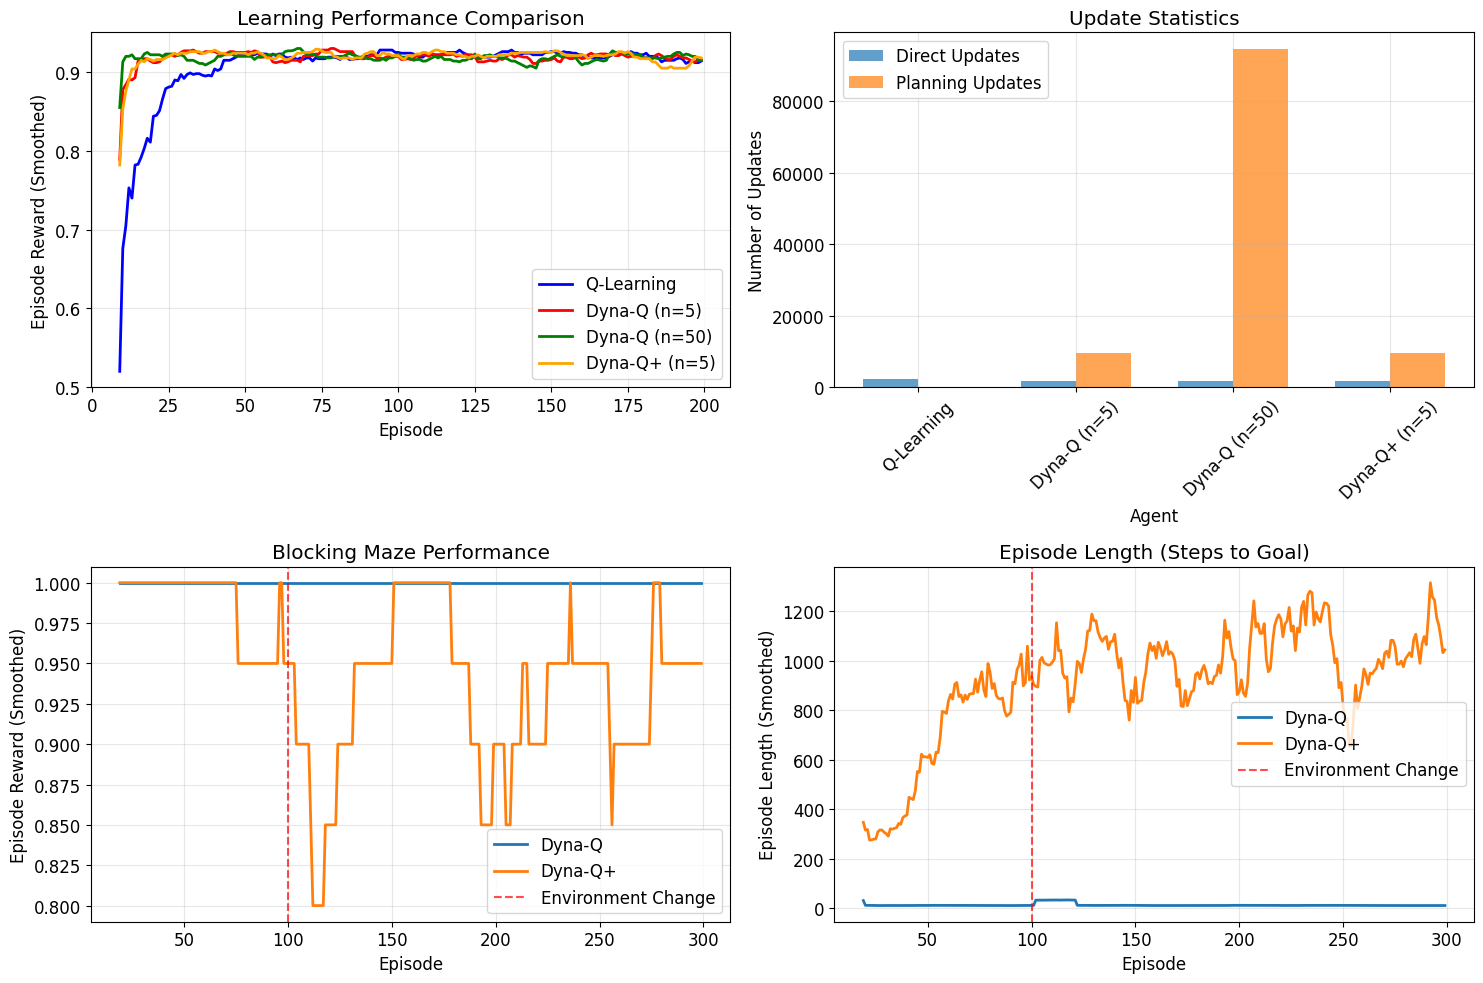


3. Key Insights from Dyna-Q Experiments:

Simple GridWorld Results:
  Q-Learning: Final Performance = 0.914, Planning Efficiency = 0.0x
  Dyna-Q (n=5): Final Performance = 0.915, Planning Efficiency = 5.0x
  Dyna-Q (n=50): Final Performance = 0.918, Planning Efficiency = 50.0x
  Dyna-Q+ (n=5): Final Performance = 0.913, Planning Efficiency = 5.0x

Blocking Maze Results (Adaptability):
  Dyna-Q: Performance before change = 1.000, after change = 1.000, adaptation = 0.000
  Dyna-Q+: Performance before change = 0.950, after change = 0.950, adaptation = 0.950

📊 Key Takeaways:
• Dyna-Q achieves better sample efficiency through planning
• More planning steps generally improve performance
• Dyna-Q+ adapts better to environment changes
• Model-based methods excel when environment is stable

2. Running MCTS demonstration...
Monte Carlo Tree Search (MCTS) Demonstration

1. Setting up environment and learned model...
Training tabular model...
Model trained with 4819.0 transitions

2. Testing MCT

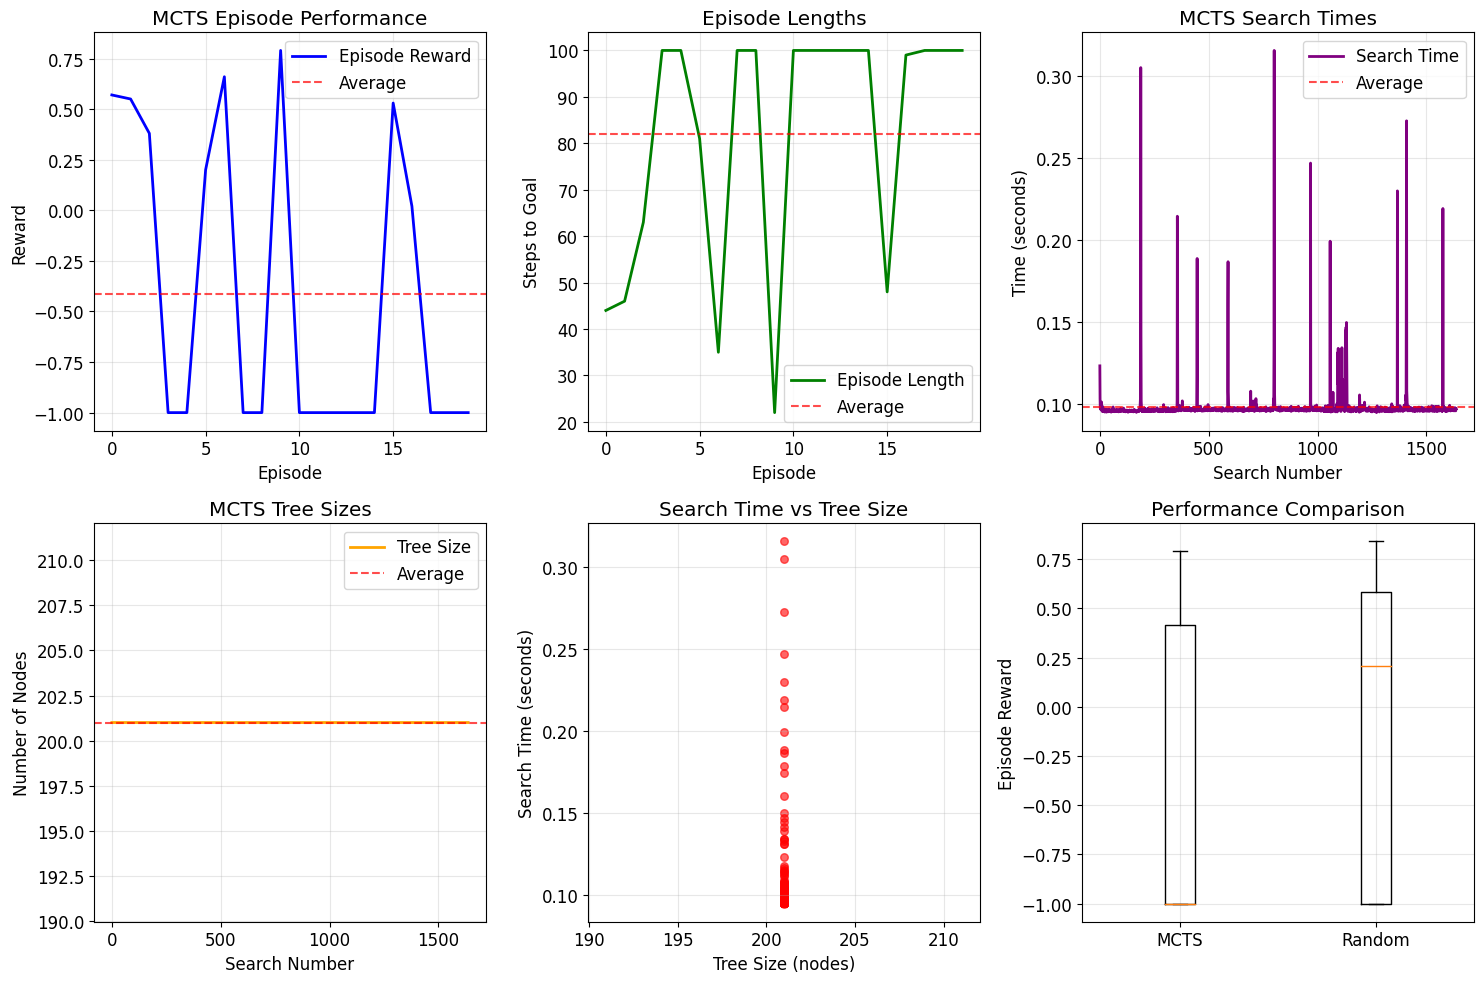


3. MCTS Performance Analysis:
Average Episode Reward: -0.415 ± 0.732
Average Episode Length: 81.9 ± 26.7
Average Search Time: 0.0982 seconds
Average Tree Size: 201.0 nodes
Total MCTS Searches: 1638

Random Policy Baseline:
Average Episode Reward: -0.062 ± 0.720

MCTS Improvement over Random: 574.8%

📊 Key MCTS Insights:
• MCTS provides sophisticated planning through tree search
• UCB balances exploration and exploitation in tree nodes
• Performance scales with number of simulations
• Computational cost grows with search depth and simulations
• Effective for discrete action spaces with learned models

3. Running MPC demonstration...
Model Predictive Control (MPC) Demonstration

1. Setting up MPC with learned model...
Collected 108857 transitions


TypeError: super(type, obj): obj must be an instance or subtype of type

In [9]:
# Comprehensive Model-Based RL Comparison and Analysis
import os
from dyna_q import demonstrate_dyna_q
from mcts import demonstrate_mcts
from mpc import demonstrate_mpc

# Create visualizations directory if it doesn't exist
os.makedirs('visualizations', exist_ok=True)

print("Running individual model-based RL demonstrations...")
print("All visualizations will be saved to the 'visualizations' folder")

# Run individual demonstrations
print("\n1. Running Dyna-Q demonstration...")
demonstrate_dyna_q()

print("\n2. Running MCTS demonstration...")
demonstrate_mcts()

print("\n3. Running MPC demonstration...")
demonstrate_mpc()

print(f"\n✅ All demonstrations complete! Check the 'visualizations' folder for saved plots.")